In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import metcalc
import scipy.stats as stat
import metpy
import pandas as pd

In [2]:
xr.__version__

'0.16.2'

Define a plotting function:

In [4]:
import matplotlib.colors as mcolors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

minColor = 0.3
maxColor = 1
purples_t = truncate_colormap(plt.get_cmap("Purples"), minColor, maxColor)

Functions for calculating trends

In [5]:
def calc_slope(x,y) :
    regression = stat.linregress(x,y)
    return regression.slope

def xr_linear_regression(ds,var,dim) :
    ''' Calculates regressions from the scipy stats module.
    The input_core_dims correspond to the coordinate you want to use for the regression
    '''
    trend = xr.apply_ufunc(
    calc_slope, ds[dim], ds[var],
    input_core_dims=[[dim],[dim]],
    dask='parallelized',
    output_dtypes=[float],
    vectorize=True
    )
    return trend.to_dataset(name='trend')


def amp_factor(ds,xvar,yvar,dim) :
    ''' Calculates regressions from the scipy stats module.
    '''
    trend = xr.apply_ufunc(
    calc_slope, ds[xvar], ds[yvar],
    input_core_dims=[[dim],[dim]],
    dask='parallelized',
    output_dtypes=[float],
    vectorize=True
    )
    return trend.to_dataset(name='trend')



In [6]:
lat_band=20

# Read Files

## ICON experiments

In [ ]:
# The preprocessing function takes the characters from the filename. These numbers [36:42] here will depend on the directory structure you use

def preproc_mm(ds):
    filename = ds.encoding['source']
    member=filename[36:43]
    ds = ds.squeeze(drop='true') 
    #member is always at the same place in the filename, as long as the data is not moved
    if 'plev' in ds.coords :
        ds.coords['plev2'] = ds.plev / 100
        ds = ds.swap_dims({'plev': 'plev2'})
        ds.plev2['units'] = 'hPa'
    #ds.coords['time'] = np.round(ds.time.values / 10000)
    ds['member'] = member
    return ds



data_mm=xr.open_mfdataset('../data/icon-param-exp/ppk00??_ta_remap63_' + str(lat_band) + 'latmean_0-360lonmean_1979-2014_mm.nc'
                       ,concat_dim='member', parallel=True, combine='nested', preprocess=preproc_mm)

In [8]:
data_cl_mm=xr.open_mfdataset('../data/icon-param-exp/ppk00??_cl_remap63_' + str(lat_band) + 'latmean_0-360lonmean_1979-2014_mm.nc'
                       ,concat_dim='member', parallel=True, combine='nested', preprocess=preproc_mm)

In [9]:
data_mm['cl'] = data_cl_mm.cl

In [10]:
def correct_time(ds) :
    '''time stamps in ICON are wrong, we need to move the months one back.'''
    ds = ds.sel(time=slice(19790201,20150101))
    ds['time'] = pd.date_range(start='1/1979', end='01/2015', freq='M')
    return ds

In [11]:
data_mm_corr = correct_time(data_mm)
data = data_mm_corr.resample(time='Y').mean().assign_coords(time = np.arange(1979.,2015.))
data = data.chunk({'time': -1})

In [12]:
data

<xarray.Dataset>
Dimensions:  (member: 54, plev2: 15, time: 36)
Coordinates:
  * time     (time) float64 1.979e+03 1.98e+03 1.981e+03 ... 2.013e+03 2.014e+03
  * member   (member) object 'ppk0002' 'ppk0010' ... 'ppk0073' 'ppk0074'
    plev     (plev2) float64 dask.array<chunksize=(15,), meta=np.ndarray>
  * plev2    (plev2) float64 1e+03 850.0 700.0 600.0 ... 50.0 25.0 15.0 10.0
Data variables:
    pfull    (time, member, plev2) float32 dask.array<chunksize=(36, 1, 15), meta=np.ndarray>
    ta       (time, member, plev2) float32 dask.array<chunksize=(36, 1, 15), meta=np.ndarray>
    cl       (time, member, plev2) float32 dask.array<chunksize=(36, 1, 15), meta=np.ndarray>

In [13]:
data_PRSST_mm=xr.open_dataset('../data/icon-param-exp/PRSST_20_all.nc')

In [14]:
data_PRSST = data_PRSST_mm.resample(time='Y').mean().assign_coords(time = np.arange(1979.,2015.))

In [15]:
data_hr_cld_mm=xr.open_mfdataset('../data/icon-param-exp/ppk00??_tend_ta_cld_remap63_' + str(lat_band) + 'latmean_0-360lonmean_1979-2014_mm.nc'
                       ,concat_dim='member', parallel=True, combine="nested", preprocess=preproc_mm)

In [16]:
data_hr_cnv_mm=xr.open_mfdataset('../data/icon-param-exp/ppk00??_tend_ta_cnv*_remap63_' + str(lat_band) + 'latmean_0-360lonmean_1979-2014_mm.nc'
                       ,concat_dim='member', parallel=True, combine="nested", preprocess=preproc_mm)

In [17]:
data_hr_dyn_mm=xr.open_mfdataset('../data/icon-param-exp/ppk00??_tend_ta_dyn*_remap63_' + str(lat_band) + 'latmean_0-360lonmean_1979-2014_mm.nc'
                       ,concat_dim='member', parallel=True, combine="nested", preprocess=preproc_mm)

In [18]:
data_hr_mm = data_hr_cnv_mm
data_hr_mm['tend_ta_cld'] = data_hr_cld_mm['tend_ta_cld']
data_hr_mm['tend_ta_dyn'] = data_hr_dyn_mm['tend_ta_dyn']

In [19]:
data_hr_mm_corr = correct_time(data_hr_mm)
data_hr = data_hr_mm_corr.resample(time='Y').mean().assign_coords(time=np.arange(1979.,2015.))

In [20]:
data_hr_tm = data_hr.mean('time') 
data_hr_tm['tend_ta_cnv'] = data_hr_tm['tend_ta_cnv'] * 3600. * 24.
data_hr_tm['tend_ta_cld'] = data_hr_tm['tend_ta_cld'] * 3600. * 24.
data_hr_tm['tend_ta_dyn'] = data_hr_tm['tend_ta_dyn'] * 3600. * 24.

In [21]:
reference_members = ['ppk0002','ppk0030','ppk0031','ppk0032','ppk0033','ppk0034','ppk0035']

In [22]:
data['PRSST']=data_PRSST.PRSST
 

data['ta700']=data.sel(plev2=700).ta
data['ta250']=data.sel(plev2=250).ta
data['ta300']=data.sel(plev2=300).ta
data['sigma']=metcalc.xr_static_stability(data).sigma
data_reference=data.sel(member=reference_members).mean('member')

data['ta-ref']=data.ta - data_reference.ta

In [23]:
data

<xarray.Dataset>
Dimensions:  (member: 54, plev2: 15, time: 36)
Coordinates:
  * time     (time) float64 1.979e+03 1.98e+03 1.981e+03 ... 2.013e+03 2.014e+03
  * member   (member) object 'ppk0002' 'ppk0010' ... 'ppk0073' 'ppk0074'
    plev     (plev2) float64 dask.array<chunksize=(15,), meta=np.ndarray>
  * plev2    (plev2) float64 1e+03 850.0 700.0 600.0 ... 50.0 25.0 15.0 10.0
Data variables:
    pfull    (time, member, plev2) float32 dask.array<chunksize=(36, 1, 15), meta=np.ndarray>
    ta       (time, member, plev2) float32 dask.array<chunksize=(36, 1, 15), meta=np.ndarray>
    cl       (time, member, plev2) float32 dask.array<chunksize=(36, 1, 15), meta=np.ndarray>
    PRSST    (time, member) float64 301.1 301.1 301.1 ... 301.7 301.7 301.7
    ta700    (time, member) float32 dask.array<chunksize=(36, 1), meta=np.ndarray>
    ta250    (time, member) float32 dask.array<chunksize=(36, 1), meta=np.ndarray>
    ta300    (time, member) float32 dask.array<chunksize=(36, 1), meta=np.ndarray>
    sigma    (time, member, plev2) float64 dask.array<chunksize=(36, 1, 15), meta=np.ndarray>
    ta-ref   (time, member, plev2) float32 dask.array<chunksize=(36, 1, 15), meta=np.ndarray>

### Organise data some more

In [24]:
low_entrpen_members = ['ppk0065','ppk0066','ppk0067','ppk0068','ppk0069']
high_entrpen_members = ['ppk0060','ppk0061','ppk0062','ppk0063','ppk0064']
very_high_entrpen_members = ['ppk0070','ppk0071','ppk0072','ppk0073','ppk0074']
high_cprcon_members = ['ppk0050','ppk0051','ppk0052','ppk0053','ppk0054']
low_cprcon_members = ['ppk0013','ppk0055','ppk0056','ppk0057','ppk0058']



In [25]:
data_low_entrpen=data.sel(member=low_entrpen_members).mean('member')
data_high_entrpen=data.sel(member=high_entrpen_members).mean('member')
data_low_cprcon=data.sel(member=low_cprcon_members).mean('member')
data_high_cprcon=data.sel(member=high_cprcon_members).mean('member')
data_very_high_entrpen=data.sel(member=very_high_entrpen_members).mean('member')



In [26]:
first_year=1979
last_year=2014

data_reference_tm = data_reference.sel(time=slice(first_year,last_year)).mean('time')
data_low_entrpen_tm = data_low_entrpen.sel(time=slice(first_year,last_year)).mean('time')
data_high_entrpen_tm = data_high_entrpen.sel(time=slice(first_year,last_year)).mean('time')
data_very_high_entrpen_tm = data_very_high_entrpen.sel(time=slice(first_year,last_year)).mean('time')
data_low_cprcon_tm = data_low_cprcon.sel(time=slice(first_year,last_year)).mean('time')
data_high_cprcon_tm = data_high_cprcon.sel(time=slice(first_year,last_year)).mean('time')


Difference in reference experiments due to internal variablity are on the order of 0.1K

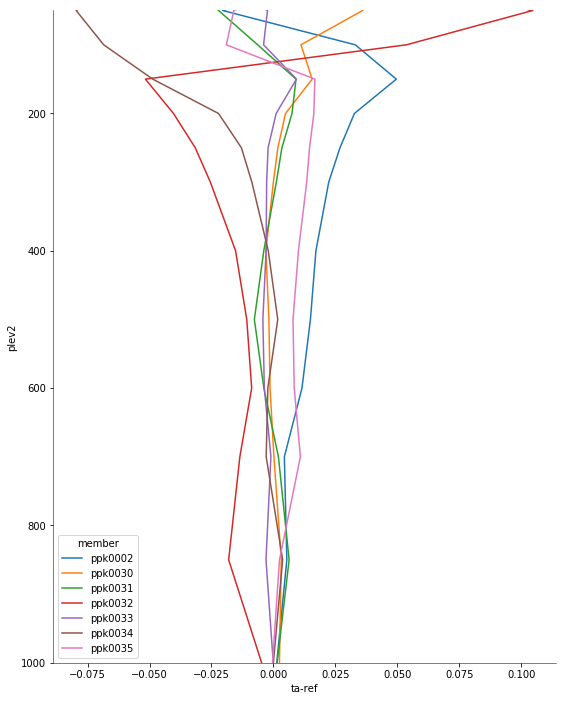

In [27]:
fig,ax = plt.subplots(figsize=(9, 12),facecolor='w')

data.sel(member=reference_members).mean('time')['ta-ref'].plot(y='plev2',hue='member')
ax.set_ylim([1000,50])
metcalc.remove_axes(ax)


## CMIP6

In [28]:
TA_AMIP_FILE   = '../data/ta/ta_tropical_mean_ym_amip.nc'
PRSST_AMIP_FILE   = '../data/PRSST/PRSST_20_amip.nc'

ta_amip = xr.open_dataset(TA_AMIP_FILE)
PRSST_amip = xr.open_dataset(PRSST_AMIP_FILE)
ta_amip['PRSST'] = PRSST_amip.PRSST

ta_amip.coords['plev2'] = ta_amip.plev / 100.
ta_amip = ta_amip.swap_dims({'plev': 'plev2'}).squeeze(drop='true')
ta_amip['ta700']=ta_amip.sel(plev2=700).ta
ta_amip['ta250']=ta_amip.sel(plev2=250).ta
ta_amip['ta300']=ta_amip.sel(plev2=300).ta
ta_amip['time'] = np.arange(1979.,2015.)
ta_amip_tm = ta_amip.mean('time')

In [29]:
ta_amip.mean('time')

<xarray.Dataset>
Dimensions:    (model_id: 40, plev2: 11)
Coordinates:
  * model_id   (model_id) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'EC-Earth3-CC'
    plev       (plev2) float64 1e+05 8.5e+04 7e+04 6e+04 ... 1.5e+04 1e+04 5e+03
    member_id  object ...
  * plev2      (plev2) float64 1e+03 850.0 700.0 600.0 ... 150.0 100.0 50.0
Data variables:
    ta         (model_id, plev2) float64 298.5 291.1 282.2 ... 204.7 191.5 208.8
    PRSST      (model_id) float64 301.5 301.4 301.5 301.5 ... 301.3 301.3 301.3
    ta700      (model_id) float64 282.2 283.1 282.6 282.5 ... 282.0 282.1 282.0
    ta250      (model_id) float64 231.5 232.1 229.5 231.6 ... 230.9 231.2 231.2
    ta300      (model_id) float64 241.4 242.2 239.8 241.7 ... 241.0 241.2 241.2

No handles with labels found to put in legend.


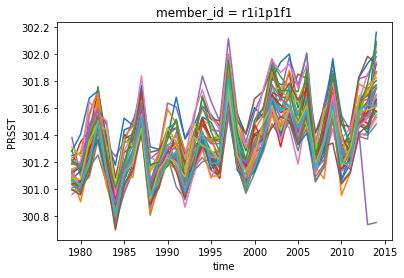

In [30]:
fig,ax = plt.subplots()
ta_amip.PRSST.plot(x="time",hue="model_id")
ax.legend().remove()

# Plot

In [31]:
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 7})

In [32]:
yticks = [1000,700,500,250,100]

## Temperature

In [33]:
temperatures = np.arange(280,284,0.1)
temp_cb = temperatures + 14.
qt=15.e-3
epsilon = 0.3
T_pseudo=[]
T_revers=[]
T_entr=[]
T_entr_700=[]
for (i,T) in enumerate(temperatures) :
    Tx_p, Px = metcalc.integrate_dTdP(T,70000.,15000.,-100., qt, formula='pseudo')
    index_250hPa = np.where( Px == 25000 )
    T_pseudo.append(Tx_p[index_250hPa])
    delta_T, Tx_entr, _ = metcalc.dT_entrainment_700(temp_cb[i],96000.,0.8,epsilon)
    T_entr.append(Tx_entr[index_250hPa])
    T_entr_700.append(Tx_entr[0])
    Tx_r, Px = metcalc.integrate_dTdP(T,70000.,15000.,-100., qt, formula='isentrope')
    T_revers.append(Tx_r[index_250hPa])


In [34]:
upper_lev=250

/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


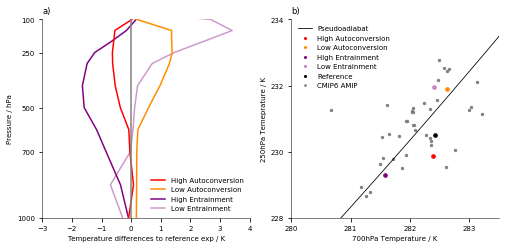

In [35]:
fig, axes = plt.subplots(1,2, figsize=(18/2.54,8.8/2.54),facecolor='w')

ax=axes[0]

data_low_entrpen_tm['ta-ref'].plot(y='plev2',color='purple',alpha=0.4,ax=ax)
data_high_entrpen_tm['ta-ref'].plot(y='plev2',color='purple',alpha=1,ax=ax)
data_high_cprcon_tm['ta-ref'].plot(y='plev2',color='red',alpha=1,ax=ax)
data_low_cprcon_tm['ta-ref'].plot(y='plev2',color='darkorange',alpha=1,ax=ax)

lines=[]
lines.append(mlines.Line2D([], [], color='red', label='High Autoconversion'))
lines.append(mlines.Line2D([], [], color='darkorange', label='Low Autoconversion'))
lines.append(mlines.Line2D([], [], color='purple', label='High Entrainment'))
lines.append(mlines.Line2D([], [], color='purple', label='Low Entrainment',alpha=0.4))

ax.plot([0,0],[1000,0],color='grey')

ax.set_ylim([1000,100])
ax.set_xlim([-3,4])
ax.set_yticks(yticks)

ax.set_xlabel('Temperature differences to reference exp / K')
ax.set_ylabel('Pressure / hPa')

metcalc.remove_axes(ax)

ax.legend(handles=lines,ncol=1,frameon=False,loc=4)
ax.set_title('a)',loc='left')

ax=axes[1]

lines=[]

# theoretical adiabats:
ax.plot(temperatures, T_pseudo, color='black',linewidth=0.8)
lines.append(mlines.Line2D([], [], color='black',linewidth=0.8, label='Pseudoadiabat'))
#ax.plot(temperatures, T_revers, color='black',linestyle='--',linewidth=0.8)
#lines.append(mlines.Line2D([], [], color='black',linewidth=0.8,linestyle='--', label='Reversible Adiabat'))
#ax.plot(T_entr_700, T_entr, color='black',linestyle='-.',linewidth=0.8)
#lines.append(mlines.Line2D([], [], color='black',linewidth=0.8,linestyle='-.', label='Entraining Plume'))

ta_amip_tm.sel(plev2=upper_lev).plot.scatter(x='ta700',y='ta',color='grey',s=5.5)


ax.scatter(x=data_low_cprcon_tm['ta700'].values,y=data_low_cprcon_tm['ta'].sel(plev2=upper_lev).values,
           color='darkorange',s=13)
ax.scatter(x=data_high_cprcon_tm['ta700'].values,y=data_high_cprcon_tm['ta'].sel(plev2=upper_lev).values,
           color='red',s=13)
ax.scatter(x=data_high_entrpen_tm['ta700'].values,y=data_high_entrpen_tm['ta'].sel(plev2=upper_lev).values,
           color='purple',s=13)
ax.scatter(x=data_low_entrpen_tm['ta700'].values,y=data_low_entrpen_tm['ta'].sel(plev2=upper_lev).values,
           color='purple',s=13,alpha=0.4)
ax.scatter(x=data_reference_tm['ta700'].values,y=data_reference_tm['ta'].sel(plev2=upper_lev).values,
           color='black',s=13)

lines.append(mlines.Line2D([], [], color='red',marker='o',markersize=2, label='High Autoconversion', linewidth=0))
lines.append(mlines.Line2D([], [], color='darkorange',marker='o',markersize=2, label='Low Autoconversion', linewidth=0))
lines.append(mlines.Line2D([], [], color='purple',marker='o',markersize=2, label='High Entrainment', linewidth=0))
lines.append(mlines.Line2D([], [], color='purple',marker='o',markersize=2, label='Low Entrainment', linewidth=0, alpha=0.4))
lines.append(mlines.Line2D([], [], color='black',marker='o',markersize=2, label='Reference', linewidth=0))
lines.append(mlines.Line2D([], [], color='grey',marker='o',markersize=1.6, label='CMIP6 AMIP', linewidth=0))

ax.set_xlabel('700hPa Temperature / K')
ax.set_ylabel(str(upper_lev) + 'hPa Temeprature / K')
ax.legend(handles=lines,ncol=1,frameon=False,loc=2)

ax.set_ylim([228,234])
ax.set_xlim([281.5,283.5])
ax.set_xticks([280,281,282,283])
ax.set_yticks([228,230,232,234])

metcalc.remove_axes(ax)
ax.set_title('b)',loc='left')


plt.savefig('../plots/icon-param-temp.pdf', dpi=600)


## Heating rates

In [36]:
data_hr_tm

<xarray.Dataset>
Dimensions:      (member: 3, plev2: 15)
Coordinates:
    plev         (plev2) float64 1e+05 8.5e+04 7e+04 ... 2.5e+03 1.5e+03 1e+03
  * plev2        (plev2) float64 1e+03 850.0 700.0 600.0 ... 50.0 25.0 15.0 10.0
  * member       (member) object 'ppk0003' 'ppk0080' 'ppk0081'
Data variables:
    pfull        (member, plev2) float32 dask.array<chunksize=(1, 15), meta=np.ndarray>
    tend_ta_cnv  (member, plev2) float32 dask.array<chunksize=(1, 15), meta=np.ndarray>
    tend_ta_cld  (member, plev2) float32 dask.array<chunksize=(1, 15), meta=np.ndarray>
    tend_ta_dyn  (member, plev2) float32 dask.array<chunksize=(1, 15), meta=np.ndarray>

/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


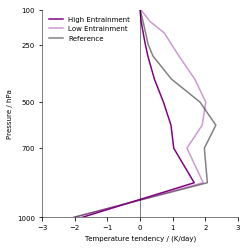

In [37]:
fig, ax = plt.subplots(1,1, figsize=(8.8/2.54,8.8/2.54),facecolor='w')
lines=[]

data_hr_tm.sel(member='ppk0003')['tend_ta_cnv'].plot(y='plev2',color='grey',alpha=1)
data_hr_tm.sel(member='ppk0080')['tend_ta_cnv'].plot(y='plev2',color='purple',alpha=1)
data_hr_tm.sel(member='ppk0081')['tend_ta_cnv'].plot(y='plev2',color='purple',alpha=0.4)


ax.plot([0,0],[1000,0],color='black',linewidth=0.5)

ax.set_ylim([1000,100])
ax.set_xlim([-3,3])
ax.set_yticks(yticks)

ax.set_xlabel('Temperature tendency / (K/day)')
ax.set_ylabel('Pressure / hPa')

metcalc.remove_axes(ax)
plt.title('')

lines.append(mlines.Line2D([], [], color='purple', label='High Entrainment'))
lines.append(mlines.Line2D([], [], color='purple', label='Low Entrainment',alpha=0.4))
lines.append(mlines.Line2D([], [], color='grey', label='Reference'))

plt.legend(handles=lines,ncol=1,frameon=False,loc=2)


Text(0.5, 1.0, '')

/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


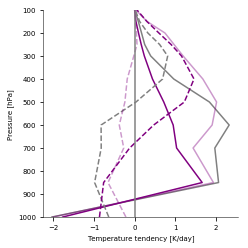

In [38]:
fig, ax = plt.subplots(1,1, figsize=(8.8/2.54,8.8/2.54),facecolor='w')


data_hr_tm.sel(member='ppk0003')['tend_ta_cnv'].plot(y='plev2',color='grey',alpha=1)
data_hr_tm.sel(member='ppk0080')['tend_ta_cnv'].plot(y='plev2',color='purple',alpha=1)
data_hr_tm.sel(member='ppk0081')['tend_ta_cnv'].plot(y='plev2',color='purple',alpha=0.4)

data_hr_tm.sel(member='ppk0003')['tend_ta_cld'].plot(y='plev2',color='grey',ls='--',alpha=1)
data_hr_tm.sel(member='ppk0080')['tend_ta_cld'].plot(y='plev2',color='purple',ls='--',alpha=1)
data_hr_tm.sel(member='ppk0081')['tend_ta_cld'].plot(y='plev2',color='purple',ls='--',alpha=0.4)



ax.plot([0,0],[1000,0],color='grey')

ax.set_ylim([1000,100])
#ax.set_xlim([-3,4])

ax.set_xlabel('Temperature tendency [K/day]')
ax.set_ylabel('Pressure [hPa]')

metcalc.remove_axes(ax)
plt.title('')



Text(0.5, 1.0, '')

/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


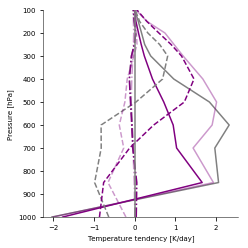

In [39]:
fig, ax = plt.subplots(1,1, figsize=(8.8/2.54,8.8/2.54),facecolor='w')


data_hr_tm.sel(member='ppk0003')['tend_ta_cnv'].plot(y='plev2',color='grey',alpha=1)
data_hr_tm.sel(member='ppk0080')['tend_ta_cnv'].plot(y='plev2',color='purple',alpha=1)
data_hr_tm.sel(member='ppk0081')['tend_ta_cnv'].plot(y='plev2',color='purple',alpha=0.4)

data_hr_tm.sel(member='ppk0003')['tend_ta_cld'].plot(y='plev2',color='grey',ls='--',alpha=1)
data_hr_tm.sel(member='ppk0080')['tend_ta_cld'].plot(y='plev2',color='purple',ls='--',alpha=1)
data_hr_tm.sel(member='ppk0081')['tend_ta_cld'].plot(y='plev2',color='purple',ls='--',alpha=0.4)

data_hr_tm.sel(member='ppk0003')['tend_ta_dyn'].plot(y='plev2',color='grey',ls='-.',alpha=1)
data_hr_tm.sel(member='ppk0080')['tend_ta_dyn'].plot(y='plev2',color='purple',ls='-.',alpha=1)
data_hr_tm.sel(member='ppk0081')['tend_ta_dyn'].plot(y='plev2',color='purple',ls='-.',alpha=0.4)


ax.plot([0,0],[1000,0],color='grey')

ax.set_ylim([1000,100])
#ax.set_xlim([-3,4])

ax.set_xlabel('Temperature tendency [K/day]')
ax.set_ylabel('Pressure [hPa]')

metcalc.remove_axes(ax)
plt.title('')



In [41]:
data_hr_tm['tend_ta_cld+cnv'] = data_hr_tm['tend_ta_cnv'] +  data_hr_tm['tend_ta_cld']

## Cloud fraction + Heating rates

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


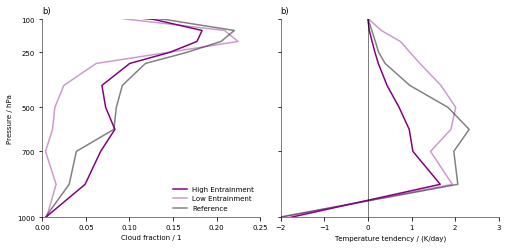

In [43]:
fig, axes = plt.subplots(1,2, figsize=(18/2.54,8.8/2.54),facecolor='w',sharey=True)

ax=axes[0]
lines=[]

data_reference_tm['cl'].plot(y='plev2',color='grey',alpha=1,ax=ax)
data_high_entrpen_tm['cl'].plot(y='plev2',color='purple',alpha=1,ax=ax)
data_low_entrpen_tm['cl'].plot(y='plev2',color='purple',alpha=0.4,ax=ax)


ax.set_ylim([1000,100])
ax.set_xlim([0,0.25])
ax.set_yticks(yticks)

ax.set_xlabel('Cloud fraction / 1')
ax.set_ylabel('Pressure / hPa')


metcalc.remove_axes(ax)
ax.set_title('')

lines.append(mlines.Line2D([], [], color='purple', label='High Entrainment'))
lines.append(mlines.Line2D([], [], color='purple', label='Low Entrainment',alpha=0.4))
lines.append(mlines.Line2D([], [], color='grey', label='Reference'))

ax.legend(handles=lines,ncol=1,frameon=False,loc=4)
ax.set_title('a)',loc='left')


ax=axes[1]

data_hr_tm.sel(member='ppk0003')['tend_ta_cnv'].plot(y='plev2',color='grey',alpha=1,ax=ax)
data_hr_tm.sel(member='ppk0080')['tend_ta_cnv'].plot(y='plev2',color='purple',alpha=1,ax=ax)
data_hr_tm.sel(member='ppk0081')['tend_ta_cnv'].plot(y='plev2',color='purple',alpha=0.4,ax=ax)


ax.plot([0,0],[1000,0],color='black',linewidth=0.5)

ax.set_ylim([1000,100])
ax.set_xlim([-2,3])
ax.set_yticks(yticks)

ax.set_xlabel('Temperature tendency / (K/day)')
ax.set_ylabel('')

metcalc.remove_axes(ax)
ax.set_title('')
ax.set_title('b)',loc='left')

plt.savefig('../plots/icon-param-entren-cl+hr.pdf', dpi=600)



## Convecting regions

In [44]:
ta_conv = xr.open_dataset('../data/icon-param-exp/all_ta_lat20_wet_90prw_ym.nc')
clw_conv = xr.open_dataset('../data/icon-param-exp/all_clw_lat20_wet_90prw_ym.nc')
cli_conv = xr.open_dataset('../data/icon-param-exp/all_cli_lat20_wet_90prw_ym.nc')

In [45]:
ta_conv

<xarray.Dataset>
Dimensions:   (member: 54, plev2: 15, time: 36)
Coordinates:
  * time      (time) float64 1.979e+03 1.98e+03 ... 2.013e+03 2.014e+03
    plev      (plev2) float64 ...
  * member    (member) object 'ppk0002' 'ppk0010' ... 'ppk0073' 'ppk0074'
  * plev2     (plev2) float64 1e+03 850.0 700.0 600.0 ... 50.0 25.0 15.0 10.0
    quantile  float64 ...
Data variables:
    pfull     (time, member, plev2) float64 ...
    ta        (time, member, plev2) float64 ...

In [46]:
ta_conv_tm = ta_conv.mean('time')
clw_conv_tm = clw_conv.mean('time')
cli_conv_tm = cli_conv.mean('time')

data_conv_tm = ta_conv_tm
data_conv_tm['clw'] = clw_conv_tm.clw * 1000.
data_conv_tm['cli'] = cli_conv_tm.cli * 1000.

data_conv_tm = data_conv_tm.drop('quantile')

In [47]:
data_conv_reference=data_conv_tm.sel(member=reference_members).mean('member')

data_conv_tm['ta-ref']=data_conv_tm.ta - data_conv_reference.ta

In [48]:
data_conv_tm

<xarray.Dataset>
Dimensions:  (member: 54, plev2: 15)
Coordinates:
    plev     (plev2) float64 1e+05 8.5e+04 7e+04 6e+04 ... 2.5e+03 1.5e+03 1e+03
  * member   (member) object 'ppk0002' 'ppk0010' ... 'ppk0073' 'ppk0074'
  * plev2    (plev2) float64 1e+03 850.0 700.0 600.0 ... 50.0 25.0 15.0 10.0
Data variables:
    pfull    (member, plev2) float64 1.011e+05 8.599e+04 ... 1.513e+03 1.009e+03
    ta       (member, plev2) float64 303.2 294.9 286.4 ... 217.1 224.0 229.0
    clw      (member, plev2) float64 0.0133 0.008955 ... -1.174e-34 8.522e-35
    cli      (member, plev2) float64 9.442e-26 4.891e-11 ... -3.976e-31
    ta-ref   (member, plev2) float64 -0.02162 -0.01428 ... -1.871 -1.898

In [49]:
data_conv_low_entrpen=data_conv_tm.sel(member=low_entrpen_members).mean('member')
data_conv_high_entrpen=data_conv_tm.sel(member=high_entrpen_members).mean('member')
data_conv_low_cprcon=data_conv_tm.sel(member=low_cprcon_members).mean('member')
data_conv_high_cprcon=data_conv_tm.sel(member=high_cprcon_members).mean('member')
data_conv_very_high_entrpen=data_conv_tm.sel(member=very_high_entrpen_members).mean('member')




### Cloud water and ice

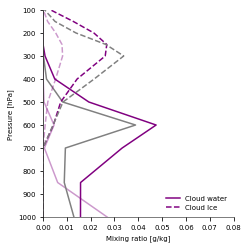

In [51]:
fig, ax = plt.subplots(1,1, figsize=(8.8/2.54,8.8/2.54),facecolor='w')

data_conv_low_entrpen['clw'].plot(y='plev2',color='purple',alpha=0.4)
data_conv_high_entrpen['clw'].plot(y='plev2',color='purple',alpha=1)
data_conv_reference['clw'].plot(y='plev2',color='grey',alpha=1)

data_conv_low_entrpen['cli'].plot(y='plev2',color='purple',alpha=0.4,ls='--')
data_conv_high_entrpen['cli'].plot(y='plev2',color='purple',alpha=1,ls='--')
data_conv_reference['cli'].plot(y='plev2',color='grey',alpha=1,ls='--')

lines=[]
lines.append(mlines.Line2D([], [], color='purple', label='Cloud water'))
lines.append(mlines.Line2D([], [], color='purple',ls='--', label='Cloud Ice'))

ax.plot([0,0],[1000,0],color='grey')

ax.set_ylim([1000,100])
ax.set_xlim([0,0.08])

ax.set_xlabel('Mixing ratio [g/kg]')
ax.set_ylabel('Pressure [hPa]')

metcalc.remove_axes(ax)

plt.legend(handles=lines,ncol=1,frameon=False,loc=4)


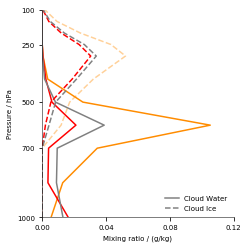

In [52]:
fig, ax = plt.subplots(1,1, figsize=(8.8/2.54,8.8/2.54),facecolor='w')

data_conv_low_cprcon['clw'].plot(y='plev2',color='darkorange')
data_conv_high_cprcon['clw'].plot(y='plev2',color='red',alpha=1)
data_conv_reference['clw'].plot(y='plev2',color='grey',alpha=1)

data_conv_low_cprcon['cli'].plot(y='plev2',color='darkorange',alpha=0.4,ls='--')
data_conv_high_cprcon['cli'].plot(y='plev2',color='red',alpha=1,ls='--')
data_conv_reference['cli'].plot(y='plev2',color='grey',alpha=1,ls='--')


lines=[]
lines.append(mlines.Line2D([], [], color='grey', label='Cloud Water'))
lines.append(mlines.Line2D([], [], color='grey',ls='--', label='Cloud Ice'))

#ax.plot([0,0],[1000,0],color='grey')

ax.set_ylim([1000,100])
ax.set_xlim([0,0.12])
ax.set_yticks(yticks)
ax.set_xticks([0,0.04,0.08,0.12])

ax.set_xlabel('Mixing ratio / (g/kg)')
ax.set_ylabel('Pressure / hPa')

metcalc.remove_axes(ax)

plt.legend(handles=lines,ncol=1,frameon=False,loc=4)


## Deviations from moist adiabat

In [53]:
data_low_entrpen

<xarray.Dataset>
Dimensions:  (plev2: 15, time: 36)
Coordinates:
  * time     (time) float64 1.979e+03 1.98e+03 1.981e+03 ... 2.013e+03 2.014e+03
    plev     (plev2) float64 dask.array<chunksize=(15,), meta=np.ndarray>
  * plev2    (plev2) float64 1e+03 850.0 700.0 600.0 ... 50.0 25.0 15.0 10.0
Data variables:
    pfull    (time, plev2) float32 dask.array<chunksize=(36, 15), meta=np.ndarray>
    ta       (time, plev2) float32 dask.array<chunksize=(36, 15), meta=np.ndarray>
    cl       (time, plev2) float32 dask.array<chunksize=(36, 15), meta=np.ndarray>
    PRSST    (time) float64 300.8 300.8 300.7 300.9 ... 301.0 301.1 301.1 301.2
    ta700    (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    ta250    (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    ta300    (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    sigma    (time, plev2) float64 dask.array<chunksize=(36, 15), meta=np.ndarray>
    ta-ref   (time, plev2) float32 dask.array<chunksize=(36, 15), meta=np.ndarray>

In [54]:
level_index = 2

In [55]:
ta_dev_low_entrpen = metcalc.deviations_from_moist_adiabat(data_low_entrpen.mean('time'),plev_i=level_index)
ta_dev_high_entrpen = metcalc.deviations_from_moist_adiabat(data_high_entrpen.mean('time'),plev_i=level_index)
ta_dev_high_cprcon = metcalc.deviations_from_moist_adiabat(data_high_cprcon.mean('time'),plev_i=level_index)
ta_dev_low_cprcon = metcalc.deviations_from_moist_adiabat(data_low_cprcon.mean('time'),plev_i=level_index)
ta_dev_reference = metcalc.deviations_from_moist_adiabat(data_reference.mean('time'),plev_i=level_index)


selected starting level: 700.0 hPa
selected starting level: 700.0 hPa
selected starting level: 700.0 hPa
selected starting level: 700.0 hPa
selected starting level: 700.0 hPa


In [57]:
level_index = 3

In [58]:
ta_dev_low_entrpen = metcalc.deviations_from_moist_adiabat(data_low_entrpen.mean('time'),plev_i=level_index)
ta_dev_high_entrpen = metcalc.deviations_from_moist_adiabat(data_high_entrpen.mean('time'),plev_i=level_index)
ta_dev_high_cprcon = metcalc.deviations_from_moist_adiabat(data_high_cprcon.mean('time'),plev_i=level_index)
ta_dev_low_cprcon = metcalc.deviations_from_moist_adiabat(data_low_cprcon.mean('time'),plev_i=level_index)
ta_dev_reference = metcalc.deviations_from_moist_adiabat(data_reference.mean('time'),plev_i=level_index)


selected starting level: 600.0 hPa
selected starting level: 600.0 hPa
selected starting level: 600.0 hPa
selected starting level: 600.0 hPa
selected starting level: 600.0 hPa


In [59]:
T = data_reference.mean('time').sel(plev2=600).ta.values
T

array(275.4608, dtype=float32)

In [60]:
qt=15.e-3

T_pseudo, Px = metcalc.integrate_dTdP(np.float(T), 60000., 15000.,-100., qt ,formula='pseudo')
T_pseudo_ice, Px = metcalc.integrate_dTdP(np.float(T), 60000.,15000.,-100., qt ,formula='pseudo-ice')
T_revers_ice, Px = metcalc.integrate_dTdP(np.float(T), 60000.,15000.,-100., qt ,formula='reversible-ice')


T_ice_dev = T_pseudo_ice - T_pseudo
T_ice_revers_dev = T_revers_ice - T_pseudo

/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


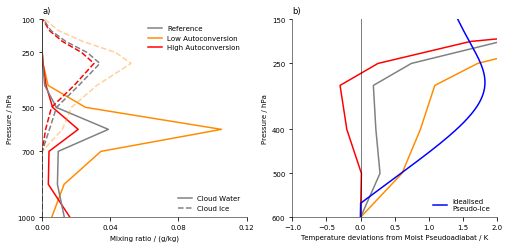

In [61]:
fig, axes = plt.subplots(1,2, figsize=(18/2.54,8.8/2.54),facecolor='w')

ax=axes[0]

data_conv_low_cprcon['clw'].plot(y='plev2',color='darkorange',ax=ax)
data_conv_high_cprcon['clw'].plot(y='plev2',color='red',alpha=1,ax=ax)
data_conv_reference['clw'].plot(y='plev2',color='grey',alpha=1,ax=ax)

data_conv_low_cprcon['cli'].plot(y='plev2',color='darkorange',alpha=0.4,ls='--',ax=ax)
data_conv_high_cprcon['cli'].plot(y='plev2',color='red',alpha=1,ls='--',ax=ax)
data_conv_reference['cli'].plot(y='plev2',color='grey',alpha=1,ls='--',ax=ax)


lines=[]
lines.append(mlines.Line2D([], [], color='grey', label='Cloud Water'))
lines.append(mlines.Line2D([], [], color='grey',ls='--', label='Cloud Ice'))

lines2=[]
lines2.append(mlines.Line2D([], [], color='grey', label='Reference'))
lines2.append(mlines.Line2D([], [], color='darkorange',ls='-', label='Low Autoconversion'))
lines2.append(mlines.Line2D([], [], color='red',ls='-', label='High Autoconversion'))


#ax.plot([0,0],[1000,0],color='grey')

ax.set_ylim([1000,100])
ax.set_xlim([0,0.12])
ax.set_yticks(yticks)
ax.set_xticks([0,0.04,0.08,0.12])

ax.set_xlabel('Mixing ratio / (g/kg)')
ax.set_ylabel('Pressure / hPa')

metcalc.remove_axes(ax)

legend1=ax.legend(handles=lines,ncol=1,frameon=False,loc=4)
ax.legend(handles=lines2,ncol=1,frameon=False,loc=1)
ax.set_title('a)',loc='left')
ax.add_artist(legend1)

ax=axes[1]

ta_dev_low_cprcon['ta'].plot(y='plev2',color='darkorange',ax=ax)
ta_dev_high_cprcon['ta'].plot(y='plev2',color='red',alpha=1,ax=ax)
ta_dev_reference['ta'].plot(y='plev2',color='grey',alpha=1,ax=ax)

ax.plot(T_ice_dev, Px/100., color='blue')

ax.plot([0,0],[1000,0],color='black',linewidth=0.5)

ax.set_ylim([600,150])
ax.set_xlim([-1,2])
ax.set_yticks([600,500,400,250,150])

lines=[]
lines.append(mlines.Line2D([], [], color='blue', label='Idealised\nPseudo-Ice'))

ax.set_xlabel('Temperature deviations from Moist Pseudoadiabat / K')
ax.set_ylabel('Pressure / hPa')

ax.legend(handles=lines,ncol=1,frameon=False,loc=4)

metcalc.remove_axes(ax)

ax.set_title('b)',loc='left')

plt.savefig('../plots/icon-param_cprcon.pdf', dpi=600)



# Warming

## Read radiosondes

In [62]:
lat_band = 20

### IUK

In [63]:

ta_obs_iuk = xr.open_dataset('../data/radiosondes/iuk_20N-20S.nc')
ta_obs_iuk = ta_obs_iuk.rename({'plev' : 'plev2', 'T_mm' : 'ta'}) + 273.15
ta_obs_iuk['ta700']=ta_obs_iuk.sel(plev2=700).ta

pandas_time=pd.date_range(start='1/1979', end='01/2009', freq='M')
pandas_time_2014 =pd.date_range(start='1/1979', end='01/2015', freq='M')

In [64]:
ta_obs_iuk_1979_2008 = ta_obs_iuk.sel(month = slice(1979011500,2008121500))

ta_obs_iuk_1979_2008['month'] = pandas_time
ta_obs_iuk_1979_2008_ym = ta_obs_iuk_1979_2008.rename({ 'month' : 'time'}).resample(time='Y').mean()
ta_obs_iuk_1979_2008_ym = ta_obs_iuk_1979_2008_ym.assign_coords(time=np.arange(1979.,2009.))

ta_obs_iuk_1979_2014 = ta_obs_iuk.sel(month = slice(1979011500,2014121500))
ta_obs_iuk_1979_2014['month'] = pandas_time_2014
ta_obs_iuk_1979_2014_ym = ta_obs_iuk_1979_2014.rename({ 'month' : 'time'}).resample(time='Y').mean()
ta_obs_iuk_1979_2014_ym = ta_obs_iuk_1979_2014_ym.assign_coords(time=np.arange(1979.,2015.))



In [65]:
ta_obs_iuk_1979_2014_ym

<xarray.Dataset>
Dimensions:                 (plev2: 12, station: 69, time: 36)
Coordinates:
  * time                    (time) float64 1.979e+03 1.98e+03 ... 2.014e+03
  * station                 (station) int32 91765 94120 78954 ... 91285 48900
  * plev2                   (plev2) float64 850.0 700.0 500.0 ... 70.0 50.0 30.0
Data variables:
    ta                      (time, plev2, station) float32 288.9 291.7 ... nan
    structural_uncertainty  (time, plev2, station) float32 273.6 ... -9.726e+03
    sample_uncertainty      (time, plev2, station) float32 273.3 ... -9.726e+03
    latlist                 (time, station) float32 258.8 260.7 ... 292.9 284.0
    lonlist                 (time, station) float32 462.4 404.0 ... 478.1 379.8
    ta700                   (time, station) float32 281.1 283.1 ... 281.8 283.4

In [66]:

ta_obs_iuk_1979_2008_ym['ta250'] = ta_obs_iuk_1979_2008_ym.sel(plev2=250).ta
ta_obs_iuk_1979_2008_ym['ta300'] = ta_obs_iuk_1979_2008_ym.sel(plev2=300).ta
ta_obs_iuk_1979_2008_ym['ta850'] = ta_obs_iuk_1979_2008_ym.sel(plev2=850).ta

ta_obs_iuk_1979_2014_ym['ta250'] = ta_obs_iuk_1979_2014_ym.sel(plev2=250).ta
ta_obs_iuk_1979_2014_ym['ta300'] = ta_obs_iuk_1979_2014_ym.sel(plev2=300).ta
ta_obs_iuk_1979_2014_ym['ta850'] = ta_obs_iuk_1979_2014_ym.sel(plev2=850).ta

### Rich

In [67]:
ta_obs_rich = xr.open_dataset('../data/radiosondes/rich15obs_mean_gridded_2017.nc')
ta_obs_rich = ta_obs_rich.rename({'pressure' : 'plev2', 'anomalies' : 'ta'})
ta_obs_rich_ym = ta_obs_rich.resample(time='Y').mean()
ta_obs_rich_ym['time'] = np.arange(1900.,2018.)
ta_obs_rich_ym_2014 = ta_obs_rich_ym.sel(time=slice(1979,2014))
ta_obs_rich_ym_tropics_2014 = metcalc.xr_fldmean(ta_obs_rich_ym_2014.sel(lat=slice(lat_band,-lat_band)))
ta_obs_rich_ym_tropics_2014['ta700'] = ta_obs_rich_ym_tropics_2014.sel(plev2=700).ta
ta_obs_rich_ym_tropics_2014['ta850'] = ta_obs_rich_ym_tropics_2014.sel(plev2=850).ta
ta_obs_rich_ym_tropics_2014['ta250'] = ta_obs_rich_ym_tropics_2014.sel(plev2=250).ta
ta_obs_rich_ym_tropics_2014['ta300'] = ta_obs_rich_ym_tropics_2014.sel(plev2=300).ta



In [68]:
def preproc_rich_ens(ds):
    filename = ds.encoding['source']
    member=filename[58:60]
    ds = ds.squeeze(drop='true') 
    ds['member'] = member
    return ds


In [69]:

ta_obs_rich_ens = xr.open_mfdataset('../data/radiosondes/rich-ensembles/rich15obs_*_gridded_2012.nc',combine='nested',preprocess=preproc_rich_ens,concat_dim='member')
ta_obs_rich_ens = ta_obs_rich_ens.rename({'pressure' : 'plev2', 'anomalies' : 'ta'})
ta_obs_rich_ym_ens = ta_obs_rich_ens.resample(time='Y').mean()
ta_obs_rich_ym_ens['time'] = np.arange(1958.,2013.)
ta_obs_rich_ens_ym_tropics = metcalc.xr_fldmean(ta_obs_rich_ym_ens.sel(lat=slice(lat_band,-lat_band)))
ta_obs_rich_ens_ym_tropics['ta700'] = ta_obs_rich_ens_ym_tropics.sel(plev2=700).ta
ta_obs_rich_ens_ym_tropics['ta850'] = ta_obs_rich_ens_ym_tropics.sel(plev2=850).ta
ta_obs_rich_ens_ym_tropics['ta250'] = ta_obs_rich_ens_ym_tropics.sel(plev2=250).ta
ta_obs_rich_ens_ym_tropics['ta300'] = ta_obs_rich_ens_ym_tropics.sel(plev2=300).ta



### Rich Tau

In [70]:

ta_tau_rich = xr.open_mfdataset('../data/radiosondes/rich-ensembles/rich15tau_*_gridded_2012.nc',combine='nested',preprocess=preproc_rich_ens,concat_dim='member')

ta_tau_rich = ta_tau_rich.rename({'pressure' : 'plev2', 'anomalies' : 'ta'})
ta_tau_rich_ym = ta_tau_rich.resample(time='Y').mean()
ta_tau_rich_ym['time'] = np.arange(1958.,2013.)
#ta_tau_rich_ym = ta_tau_rich_ym.sel(time=slice(1979,2014))
ta_tau_rich_ym_tropics = metcalc.xr_fldmean(ta_tau_rich_ym.sel(lat=slice(lat_band,-lat_band)))
ta_tau_rich_ym_tropics['ta700'] = ta_tau_rich_ym_tropics.sel(plev2=700).ta
ta_tau_rich_ym_tropics['ta850'] = ta_tau_rich_ym_tropics.sel(plev2=850).ta
ta_tau_rich_ym_tropics['ta250'] = ta_tau_rich_ym_tropics.sel(plev2=250).ta
ta_tau_rich_ym_tropics['ta300'] = ta_tau_rich_ym_tropics.sel(plev2=300).ta



In [71]:
ta_tau_rich_ym_tropics

,Array,Chunk
Bytes,84.48 kB,48 B
Shape,"(55, 32, 12)","(1, 1, 12)"
Count,31809 Tasks,1760 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.04 kB,4 B
Shape,"(55, 32)","(1, 1)"
Count,33569 Tasks,1760 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### Raobcore

In [72]:

ta_raobcore = xr.open_dataset('../data/radiosondes/raobcore15_gridded_2017.nc')
ta_raobcore = ta_raobcore.rename({'pressure' : 'plev2', 'anomalies' : 'ta'})
ta_raobcore_ym = ta_raobcore.resample(time='Y').mean()
ta_raobcore_ym['time'] = np.arange(1900.,2018.)
ta_raobcore_ym_2014 = ta_raobcore_ym.sel(time=slice(1979,2014))
ta_raobcore_ym_tropics_2014 = metcalc.xr_fldmean(ta_raobcore_ym_2014.sel(lat=slice(lat_band,-lat_band)))
ta_raobcore_ym_tropics_2014['ta700'] = ta_raobcore_ym_tropics_2014.sel(plev2=700).ta
ta_raobcore_ym_tropics_2014['ta850'] = ta_raobcore_ym_tropics_2014.sel(plev2=850).ta
ta_raobcore_ym_tropics_2014['ta250'] = ta_raobcore_ym_tropics_2014.sel(plev2=250).ta
ta_raobcore_ym_tropics_2014['ta300'] = ta_raobcore_ym_tropics_2014.sel(plev2=300).ta

### RATPAC-A

In [73]:

ratpac_csv=pd.read_csv('../data/radiosondes/RATPAC-A-annual-20N-20S.txt', delim_whitespace=True)
ratpac_csv = ratpac_csv.set_index('year')

levels_ratpac = ratpac_csv.columns.drop(['surf'])
levels_ratpac.values

array(['850', '700', '500', '400', '300', '250', '200', '150', '100',
       '70', '50', '30'], dtype=object)

In [74]:
da_list=[]

for lev in levels_ratpac.values :
    da = ratpac_csv[lev].to_xarray()
    da_list.append(da)

level_ar = xr.DataArray(levels_ratpac.values.astype(int), name='plev2',dims='plev2')

#make new Data Array for whole ensemble
ta_ratpac_da = xr.concat(da_list, level_ar)

ta_ratpac = ta_ratpac_da.to_dataset(name='ta')
ta_ratpac['ta700'] = ta_ratpac.sel(plev2=700).ta
ta_ratpac['ta850'] = ta_ratpac.sel(plev2=850).ta
ta_ratpac['ta250'] = ta_ratpac.sel(plev2=250).ta
ta_ratpac['ta300'] = ta_ratpac.sel(plev2=300).ta


ta_ratpac_ym_tropical_mean = ta_ratpac.rename({'year': 'time'}).sel(time=slice(1979,2014))
ta_ratpac_ym_tropical_mean['time']=np.arange(1979.,2015.)

### HADAT

In [75]:
ta_hadat = xr.open_dataset('../data/radiosondes/hadat2_monthly_zonal_and_global.nc').zonal
ta_hadat = ta_hadat.rename({'pressure': 'plev2'}).squeeze(drop='true')

ta_hadat = ta_hadat.to_dataset(name = 'ta')
ta_hadat



<xarray.Dataset>
Dimensions:  (lat: 36, plev2: 9, time: 660)
Coordinates:
  * lat      (lat) float32 87.5 82.5 77.5 72.5 67.5 ... -72.5 -77.5 -82.5 -87.5
  * time     (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2012-12-01
  * plev2    (plev2) float32 850.0 700.0 500.0 300.0 200.0 150.0 100.0 50.0 30.0
Data variables:
    ta       (time, plev2, lat) float32 ...

In [76]:
ta_hadat_ym = ta_hadat.resample(time='Y').mean()
ta_hadat_ym['time'] = np.arange(1958.,2013.)
ta_hadat_tropical_mean = metcalc.xr_fldmean(ta_hadat_ym.sel(lat=slice(lat_band,-lat_band)))

# interpolate to more levels:
ta_hadat_tropical_mean = ta_hadat_tropical_mean.interp_like(ta_obs_iuk_1979_2008_ym.mean("station"))
ta_hadat_1979_2008 = ta_hadat_tropical_mean.sel(time=slice(1979,2008))
ta_hadat_1979_2012 = ta_hadat_tropical_mean.sel(time=slice(1979,2012))


In [77]:

ta_hadat_1979_2008['ta700']=ta_hadat_1979_2008.sel(plev2=700).ta
ta_hadat_1979_2008['ta300']=ta_hadat_1979_2008.sel(plev2=300).ta
ta_hadat_1979_2008['ta250']=ta_hadat_1979_2008.sel(plev2=250).ta
ta_hadat_1979_2008['ta850']=ta_hadat_1979_2008.sel(plev2=850).ta


In [78]:

ta_hadat_1979_2012['ta700']=ta_hadat_1979_2012.sel(plev2=700).ta
ta_hadat_1979_2012['ta300']=ta_hadat_1979_2012.sel(plev2=300).ta
ta_hadat_1979_2012['ta250']=ta_hadat_1979_2012.sel(plev2=250).ta
ta_hadat_1979_2012['ta850']=ta_hadat_1979_2012.sel(plev2=850).ta


### SUNY

In [79]:
ta_suny = xr.open_dataset('../data/radiosondes/UA-HRD_5x5grids_homo-monthly-anomalyT_195801-202008.nc')

ta_suny['pres'] = ta_suny.pres /100.

# a lot of missing data here which of course disappears in the fieldmean calcualtion...
ta_suny_2014 = ta_suny.sel(time=slice(197901,201412),lat=slice(lat_band,-lat_band)).rename({'pres': 'plev2'}).rename({'temperature': 'ta'})
ta_suny_2014_tropical_mean = metcalc.xr_fldmean(ta_suny_2014)

In [80]:
ta_suny_2014_tropical_mean['time'] = pandas_time_2014

ta_suny_2014_ym = ta_suny_2014_tropical_mean.resample(time='Y').mean()
ta_suny_2014_ym = ta_suny_2014_ym.assign_coords(time=np.arange(1979.,2015.))
ta_suny_2014_ym

<xarray.Dataset>
Dimensions:  (plev2: 15, time: 36)
Coordinates:
  * time     (time) float64 1.979e+03 1.98e+03 1.981e+03 ... 2.013e+03 2.014e+03
  * plev2    (plev2) float64 10.0 20.0 30.0 50.0 ... 500.0 700.0 850.0 1e+03
Data variables:
    ta       (time, plev2) float32 1.047 0.5825 0.4118 ... 0.3354 0.288 0.2642

In [81]:
ta_suny_2014_ym['ta700'] = ta_suny_2014_ym.sel(plev2=700).ta
ta_suny_2014_ym['ta850'] = ta_suny_2014_ym.sel(plev2=850).ta
ta_suny_2014_ym['ta250'] = ta_suny_2014_ym.sel(plev2=250).ta
ta_suny_2014_ym['ta300'] = ta_suny_2014_ym.sel(plev2=300).ta

### ERA5

In [88]:
ERA_FILE = '../data/era5/era5_T_mm_tropicalmean_' + lat_bound +'lat_1979-2014.nc'
ERA51_FILE = '../data/era5/era5.1_T_mm_tropicalmean_' + lat_bound +'lat_1979-2014.nc'
ERA_PRSST = '../data/era5/PRSST_era5_20.nc'

ta_era = xr.open_dataset(ERA_FILE).T
ta_era.coords['plev2'] = ta_era.plev / 100.
ta_era = ta_era.swap_dims({'plev': 'plev2'}).squeeze(drop='true').to_dataset(name="ta")
ta_era['time'] = np.arange(1979.,2015.)
ta_era_1979_1999 = ta_era.sel(time=slice(1979,1999))
ta_era_2007_2014 = ta_era.sel(time=slice(2007,2014))

ta_era51 = xr.open_dataset(ERA51_FILE).T
ta_era51.coords['plev2'] = ta_era51.plev / 100.
ta_era51 = ta_era51.swap_dims({'plev': 'plev2'}).squeeze(drop='true').to_dataset(name="ta")
ta_era51 = ta_era51.sortby("time").resample(time='Y').mean().assign_coords(time = np.arange(2000.,2007.))

ta_era5 = xr.concat([ta_era_1979_1999,ta_era51,ta_era_2007_2014],"time")

ta_era['ta850']=ta_era.sel(plev2=850).ta
ta_era['ta700']=ta_era.sel(plev2=700).ta
ta_era['ta250'] = ta_era.sel(plev2=250).ta
ta_era['ta300'] = ta_era.sel(plev2=300).ta


ta_era_2014 = ta_era
ta_era = ta_era.sel(time=slice(1979,2008))

PRSST_era_mm = xr.open_dataset(ERA_PRSST)
PRSST_era = PRSST_era_mm.resample(time='Y').mean()
PRSST_era['time'] = np.arange(1979.,2015.) 

ta_era

<xarray.Dataset>
Dimensions:  (plev2: 11, time: 30)
Coordinates:
  * time     (time) float64 1.979e+03 1.98e+03 1.981e+03 ... 2.007e+03 2.008e+03
    plev     (plev2) float64 5e+03 1e+04 1.5e+04 2e+04 ... 7e+04 8.5e+04 1e+05
  * plev2    (plev2) float64 50.0 100.0 150.0 200.0 ... 600.0 700.0 850.0 1e+03
Data variables:
    ta       (time, plev2) float32 ...
    ta850    (time) float32 ...
    ta700    (time) float32 ...
    ta250    (time) float32 ...
    ta300    (time) float32 ...

## Amplification factor
### 250 hPa

In [90]:

amp_factor_reference_2012 = amp_factor(ds=data.sel(member=reference_members,time=slice(1979,2012)), xvar='ta700',yvar='ta250', dim='time')
amp_factor_low_entrpen_2012 = amp_factor(ds=data.sel(member=low_entrpen_members,time=slice(1979,2012)), xvar='ta700',yvar='ta250', dim='time')
amp_factor_high_entrpen_2012 = amp_factor(ds=data.sel(member=high_entrpen_members,time=slice(1979,2012)), xvar='ta700',yvar='ta250', dim='time')
amp_factor_very_high_entrpen_2012 = amp_factor(ds=data.sel(member=very_high_entrpen_members,time=slice(1979,2012)), xvar='ta700',yvar='ta250', dim='time')
amp_factor_low_cprcon_2012 = amp_factor(ds=data.sel(member=low_cprcon_members,time=slice(1979,2012)), xvar='ta700',yvar='ta250', dim='time')
amp_factor_high_cprcon_2012 = amp_factor(ds=data.sel(member=high_cprcon_members,time=slice(1979,2012)), xvar='ta700',yvar='ta250', dim='time')


In [92]:
amp_factor_era_2012 = amp_factor(ds=ta_era.sel(time=slice(1979,2012)), xvar='ta700',yvar='ta250', dim='time')
amp_factor_era_2014 = amp_factor(ds=ta_era_2014, xvar='ta700',yvar='ta250', dim='time')

amp_factor_cmip6_2012 = amp_factor(ds=ta_amip.sel(time=slice(1979,2012)), xvar='ta700',yvar='ta250', dim='time')
amp_factor_cmip6_2014 = amp_factor(ds=ta_amip, xvar='ta700',yvar='ta250', dim='time')



In [93]:
amp_factor_IUK_2012 = amp_factor(ds=ta_obs_iuk_1979_2014_ym.mean('station').sel(time=slice(1979,2012)), xvar='ta700',yvar='ta250', dim='time')
amp_factor_IUK_2014 = amp_factor(ds=ta_obs_iuk_1979_2014_ym.mean('station'), xvar='ta700',yvar='ta250', dim='time')

amp_factor_rich_obs_2012 = amp_factor(ds=ta_obs_rich_ens_ym_tropics.sel(time=slice(1979,2012)).load(), xvar='ta700',yvar='ta250', dim='time')
amp_factor_rich_obs_2014 = amp_factor(ds=ta_obs_rich_ym_tropics_2014.load(), xvar='ta700',yvar='ta250', dim='time')
amp_factor_rich_tau_2012 = amp_factor(ds=ta_tau_rich_ym_tropics.sel(time=slice(1979,2012)).load(), xvar='ta700',yvar='ta250', dim='time')

amp_factor_raobcore_2012 = amp_factor(ds=ta_raobcore_ym_tropics_2014.sel(time=slice(1979,2012)), xvar='ta700',yvar='ta250', dim='time')
amp_factor_raobcore_2014 = amp_factor(ds=ta_raobcore_ym_tropics_2014, xvar='ta700',yvar='ta250', dim='time')

amp_factor_ratpac_2012 = amp_factor(ds=ta_ratpac_ym_tropical_mean.sel(time=slice(1979,2012)), xvar='ta700',yvar='ta250', dim='time')
amp_factor_ratpac_2014 = amp_factor(ds=ta_ratpac_ym_tropical_mean, xvar='ta700',yvar='ta250', dim='time')

amp_factor_suny_2012 = amp_factor(ds=ta_suny_2014_ym.sel(time=slice(1979,2012)), xvar='ta700',yvar='ta250', dim='time')
amp_factor_suny_2014 = amp_factor(ds=ta_suny_2014_ym, xvar='ta700',yvar='ta250', dim='time')

amp_factor_hadat_2012 = amp_factor(ds=ta_hadat_1979_2012, xvar='ta700',yvar='ta250', dim='time')

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [94]:
print(epsilon)

0.3


In [95]:
temperatures = np.arange(281,284,0.1)

qt=15.e-3
T_pseudo=[]
T_revers=[]
T_pseudo_ice=[]
T_isentrope_ice=[]
T_entr = []
T_entr_700 = []

for T in temperatures :
    Tx_p, Px = metcalc.integrate_dTdP(T,70000.,15000.,-100., qt, formula='pseudo')
    index_250hPa = np.where( Px == 25000 )
    T_pseudo.append(Tx_p[index_250hPa])
    Tx_r, Px = metcalc.integrate_dTdP(T,70000.,15000.,-100., qt, formula='isentrope')
    T_revers.append(Tx_r[index_250hPa])
    Tx_pi, Px = metcalc.integrate_dTdP(T,70000.,15000.,-100., qt, formula='pseudo-ice')
    T_pseudo_ice.append(Tx_pi[index_250hPa])
    Tx_ri, Px = metcalc.integrate_dTdP(T,70000.,15000.,-100., qt, formula='ice-isentrope')
    T_isentrope_ice.append(Tx_ri[index_250hPa])
    delta_T, Tx_entr, Px = metcalc.dT_entrainment_700(T+14.,96000.,0.8,epsilon)
    T_entr.append(Tx_entr[index_250hPa])
    T_entr_700.append(Tx_entr[0])

amp_factor_pseudo = calc_slope(list(temperatures), [ float(l) for l in T_pseudo ])
amp_factor_revers = calc_slope(list(temperatures), [ float(l) for l in T_revers ])
amp_factor_pseudo_ice = calc_slope(list(temperatures), [ float(l) for l in T_pseudo_ice ])
amp_factor_isentrope_ice = calc_slope(list(temperatures), [ float(l) for l in T_isentrope_ice ])
amp_factor_entr = calc_slope(T_entr_700, [ float(l) for l in T_entr ])

print(amp_factor_pseudo)
print(amp_factor_revers)
print(amp_factor_pseudo_ice)
print(amp_factor_isentrope_ice)
print(amp_factor_entr)

2.0764882560366265
1.9580625715899918
2.1440565852554423
2.0898961904247253
2.0599203732153764


In [96]:
# chosing T_cb = 293.1054 to 295.54195 ensures a similar range as for the pseudoadiabat
# that we chose above (281 to 284 at 700hPa) for entrainment = 0

temperatures_cb = np.linspace(293.1054,295.54195,30)

entrainment_rates=np.arange(0,1,0.1)
amp_factor_entr_list = []

for e in entrainment_rates :
    T_entr = []
    T_entr_700 = []
    for T in temperatures_cb :
        delta_T, Tx_e, _ = metcalc.dT_entrainment_700(T,96000.,0.8,e)
        T_entr.append(Tx_e[index_250hPa])
        T_entr_700.append(Tx_e[0])
        
    amp_factor_entr = calc_slope(T_entr_700, [ float(l) for l in T_entr ])
    amp_factor_entr_list.append(amp_factor_entr)


In [97]:
amp_factor_entr_list

[2.0643887065408433,
 2.0120648427183956,
 1.9588589335858155,
 1.9047484882034325,
 1.849710244501547,
 1.7937201359488955,
 1.736753256477569,
 1.6787838235567716,
 1.6197851393005078,
 1.5597295494859025]

In [98]:

cmip6_dummy = ['CMIP6 AMIP'] * len(amp_factor_cmip6_2014.trend.values)
reference_dummy =  ['ICON-A reference'] * len(amp_factor_reference.trend.values)
entr_low_dummy =  ['low entrainment'] * len(amp_factor_low_entrpen.trend.values)
entr_high_dummy =  ['high entrainment'] * len(amp_factor_high_entrpen.trend.values)
entr_very_high_dummy =  ['very high entrainment'] * len(amp_factor_very_high_entrpen.trend.values)
cprcon_low_dummy =  ['low autoconversion'] * len(amp_factor_low_cprcon.trend.values)
cprcon_high_dummy =  ['high autoconversion'] * len(amp_factor_high_cprcon.trend.values)


/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


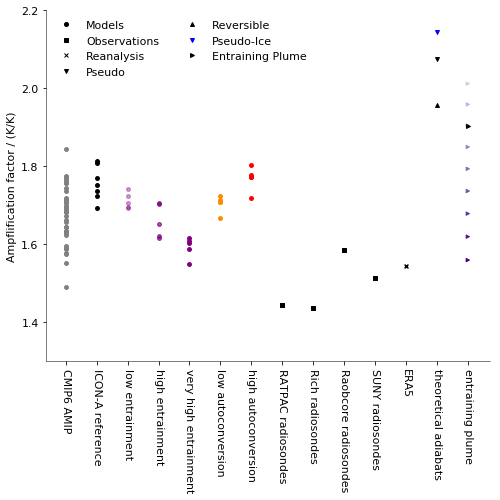

In [99]:
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 11})
lines=[]

fig, ax = plt.subplots(1,1, figsize=(18/2.54,18/2.54),facecolor='w')

ax.scatter(x=cmip6_dummy,y=amp_factor_cmip6_2014.trend.values, color='grey',s=15)

ax.scatter(x=reference_dummy,y=amp_factor_reference.trend.values, color='black',s=15)

ax.scatter(x=entr_low_dummy,y=amp_factor_low_entrpen.trend.values, color='purple',s=15,alpha=0.4)
ax.scatter(x=entr_high_dummy,y=amp_factor_high_entrpen.trend.values, color='purple',s=15,alpha=0.7)
ax.scatter(x=entr_very_high_dummy,y=amp_factor_very_high_entrpen.trend.values, color='purple',s=15)

ax.scatter(x=cprcon_low_dummy,y=amp_factor_low_cprcon.trend.values, color='darkorange',s=15)
ax.scatter(x=cprcon_high_dummy,y=amp_factor_high_cprcon.trend.values, color='red',s=15)

#ax.scatter(x='IUK radiosondes',y=amp_factor_IUK_2014.trend.values,color='black', marker='s',s=15)
ax.scatter(x='RATPAC radiosondes',y=amp_factor_ratpac_2014.trend.values,color='black', marker='s',s=15)
ax.scatter(x='Rich radiosondes',y=amp_factor_rich_obs_2014.trend.values,color='black', marker='s',s=15)
ax.scatter(x='Raobcore radiosondes',y=amp_factor_raobcore_2014.trend.values,color='black', marker='s',s=15)
ax.scatter(x='SUNY radiosondes',y=amp_factor_suny_2014.trend.values,color='black', marker='s',s=15)


ax.scatter(x='ERA5',y=amp_factor_era_2014.trend.values,color='black', marker='x',s=15)

ax.scatter(x='theoretical adiabats',y=amp_factor_revers,color='black', marker='^',s=15)
ax.scatter(x='theoretical adiabats',y=amp_factor_pseudo_ice,color='blue', marker='v',s=15)
ax.scatter(x='theoretical adiabats',y=amp_factor_pseudo,color='black', marker='v',s=15)
ax.scatter(x=['entraining plume']*9,y=amp_factor_entr_list[1:10],cmap=purples_t,c=entrainment_rates[1:10], marker='>',s=11)
ax.scatter(x='entraining plume',y=amp_factor_entr_list[3],color='black', marker='>',s=15)
lines.append(mlines.Line2D([], [], color='black',marker='o', label='Models',linewidth=0,markersize=4))
lines.append(mlines.Line2D([], [], color='black',marker='s', label='Observations',linewidth=0,markersize=4))
lines.append(mlines.Line2D([], [], color='black',marker='x', label='Reanalysis',linewidth=0,markersize=4))
lines.append(mlines.Line2D([], [], color='black',marker='v', label='Pseudo',linewidth=0,markersize=4))
lines.append(mlines.Line2D([], [], color='black',marker='^', label='Reversible',linewidth=0,markersize=4))
lines.append(mlines.Line2D([], [], color='blue',marker='v', label='Pseudo-Ice',linewidth=0,markersize=4))
lines.append(mlines.Line2D([], [], color='black',marker='>', label='Entraining Plume',linewidth=0,markersize=4))

metcalc.remove_axes(ax)
    
ax.set_xlabel('')
ax.set_ylabel('Ampflification factor / (K/K)')
ax.set_ylim([1.3,2.2])
ax.set_yticks([1.4,1.6,1.8,2.0,2.2])

ax.xaxis.set_tick_params(rotation=270)

ax.legend(handles=lines, loc=2, ncol=2,framealpha=0)


### 1979-2012

In [100]:
amp_factor_reference_2012.trend.values

array([1.73740944, 1.76314438, 1.77667293, 1.73374015, 1.69847163,
       1.70183129, 1.81949191])

In [101]:
amp_factor_high_entrpen_2012.trend.values

array([1.68098421, 1.68182797, 1.63393762, 1.62372982, 1.6255531 ])

/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


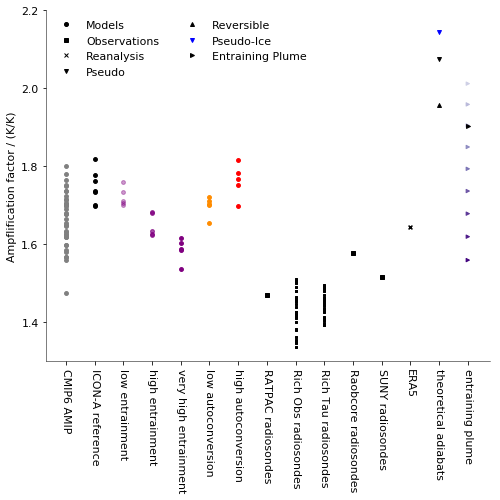

In [102]:
rich_obs_dummy = ['Rich Obs radiosondes']*len(amp_factor_rich_obs_2012.trend.values)
rich_tau_dummy = ['Rich Tau radiosondes']*len(amp_factor_rich_tau_2012.trend.values)

plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 11})
lines=[]

fig, ax = plt.subplots(1,1, figsize=(18/2.54,18/2.54),facecolor='w')

ax.scatter(x=cmip6_dummy,y=amp_factor_cmip6_2012.trend.values, color='grey',s=15)

ax.scatter(x=reference_dummy,y=amp_factor_reference_2012.trend.values, color='black',s=15)

ax.scatter(x=entr_low_dummy,y=amp_factor_low_entrpen_2012.trend.values, color='purple',s=15,alpha=0.4)
ax.scatter(x=entr_high_dummy,y=amp_factor_high_entrpen_2012.trend.values, color='purple',s=15,alpha=0.7)
ax.scatter(x=entr_very_high_dummy,y=amp_factor_very_high_entrpen_2012.trend.values, color='purple',s=15)

ax.scatter(x=cprcon_low_dummy,y=amp_factor_low_cprcon_2012.trend.values, color='darkorange',s=15)
ax.scatter(x=cprcon_high_dummy,y=amp_factor_high_cprcon_2012.trend.values, color='red',s=15)

#ax.scatter(x='IUK radiosondes',y=amp_factor_IUK_2012.trend.values,color='black', marker='s',s=15)
ax.scatter(x='RATPAC radiosondes',y=amp_factor_ratpac_2012.trend.values,color='black', marker='s',s=15)
ax.scatter(x=rich_obs_dummy,y=amp_factor_rich_obs_2012.trend.values,color='black', marker='s',s=8)
ax.scatter(x=rich_tau_dummy,y=amp_factor_rich_tau_2012.trend.values,color='black', marker='s',s=8)

ax.scatter(x='Raobcore radiosondes',y=amp_factor_raobcore_2012.trend.values,color='black', marker='s',s=15)
ax.scatter(x='SUNY radiosondes',y=amp_factor_suny_2012.trend.values,color='black', marker='s',s=15)


ax.scatter(x='ERA5',y=amp_factor_era_2012.trend.values,color='black', marker='x',s=15)

ax.scatter(x='theoretical adiabats',y=amp_factor_revers,color='black', marker='^',s=15)
ax.scatter(x='theoretical adiabats',y=amp_factor_pseudo_ice,color='blue', marker='v',s=15)
ax.scatter(x='theoretical adiabats',y=amp_factor_pseudo,color='black', marker='v',s=15)
ax.scatter(x=['entraining plume']*9,y=amp_factor_entr_list[1:10],cmap=purples_t,c=entrainment_rates[1:10], marker='>',s=11)
ax.scatter(x='entraining plume',y=amp_factor_entr_list[3],color='black', marker='>',s=15)
lines.append(mlines.Line2D([], [], color='black',marker='o', label='Models',linewidth=0,markersize=4))
lines.append(mlines.Line2D([], [], color='black',marker='s', label='Observations',linewidth=0,markersize=4))
lines.append(mlines.Line2D([], [], color='black',marker='x', label='Reanalysis',linewidth=0,markersize=4))
lines.append(mlines.Line2D([], [], color='black',marker='v', label='Pseudo',linewidth=0,markersize=4))
lines.append(mlines.Line2D([], [], color='black',marker='^', label='Reversible',linewidth=0,markersize=4))
lines.append(mlines.Line2D([], [], color='blue',marker='v', label='Pseudo-Ice',linewidth=0,markersize=4))
lines.append(mlines.Line2D([], [], color='black',marker='>', label='Entraining Plume',linewidth=0,markersize=4))

metcalc.remove_axes(ax)
    
ax.set_xlabel('')
ax.set_ylabel('Ampflification factor / (K/K)')
ax.set_ylim([1.3,2.2])
ax.set_yticks([1.4,1.6,1.8,2.0,2.2])

ax.xaxis.set_tick_params(rotation=270)

ax.legend(handles=lines, loc=2, ncol=2,framealpha=0)


### 300hPa
Repeat for 300hPa

In [103]:

amp_factor_reference = amp_factor(ds=data.sel(member=reference_members), xvar='ta700',yvar='ta300', dim='time')
amp_factor_low_entrpen = amp_factor(ds=data.sel(member=low_entrpen_members), xvar='ta700',yvar='ta300', dim='time')
amp_factor_high_entrpen = amp_factor(ds=data.sel(member=high_entrpen_members), xvar='ta700',yvar='ta300', dim='time')
amp_factor_very_high_entrpen = amp_factor(ds=data.sel(member=very_high_entrpen_members), xvar='ta700',yvar='ta300', dim='time')
amp_factor_low_cprcon = amp_factor(ds=data.sel(member=low_cprcon_members), xvar='ta700',yvar='ta300', dim='time')
amp_factor_high_cprcon = amp_factor(ds=data.sel(member=high_cprcon_members), xvar='ta700',yvar='ta300', dim='time')


In [104]:
amp_factor_era_2008 = amp_factor(ds=ta_era, xvar='ta700',yvar='ta300', dim='time')
amp_factor_era_2014 = amp_factor(ds=ta_era_2014, xvar='ta700',yvar='ta300', dim='time')

amp_factor_cmip6_2008 = amp_factor(ds=ta_amip.sel(time=slice(1979,2008)), xvar='ta700',yvar='ta300', dim='time')
amp_factor_cmip6_2014 = amp_factor(ds=ta_amip, xvar='ta700',yvar='ta300', dim='time')



In [105]:
amp_factor_IUK_2008 = amp_factor(ds=ta_obs_iuk_1979_2008_ym.mean('station'), xvar='ta700',yvar='ta300', dim='time')
amp_factor_IUK_2014 = amp_factor(ds=ta_obs_iuk_1979_2014_ym.mean('station'), xvar='ta700',yvar='ta300', dim='time')

amp_factor_rich_2008 = amp_factor(ds=ta_obs_rich_ym_tropics_2014.sel(time=slice(1979,2008)), xvar='ta700',yvar='ta300', dim='time')
amp_factor_rich_2014 = amp_factor(ds=ta_obs_rich_ym_tropics_2014, xvar='ta700',yvar='ta300', dim='time')

amp_factor_raobcore_2008 = amp_factor(ds=ta_raobcore_ym_tropics_2014.sel(time=slice(1979,2008)), xvar='ta700',yvar='ta300', dim='time')
amp_factor_raobcore_2014 = amp_factor(ds=ta_raobcore_ym_tropics_2014, xvar='ta700',yvar='ta300', dim='time')

amp_factor_ratpac_2008 = amp_factor(ds=ta_ratpac_ym_tropical_mean.sel(time=slice(1979,2008)), xvar='ta700',yvar='ta300', dim='time')
amp_factor_ratpac_2014 = amp_factor(ds=ta_ratpac_ym_tropical_mean, xvar='ta700',yvar='ta300', dim='time')

amp_factor_hadat_2008 = amp_factor(ds=ta_hadat_1979_2008, xvar='ta700',yvar='ta300', dim='time')

/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


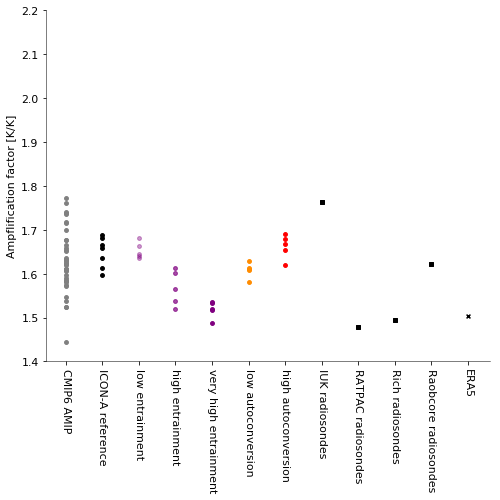

In [106]:
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 11})
lines=[]

fig, ax = plt.subplots(1,1, figsize=(18/2.54,18/2.54),facecolor='w')

ax.scatter(x=cmip6_dummy,y=amp_factor_cmip6_2014.trend.values, color='grey',s=15)

ax.scatter(x=reference_dummy,y=amp_factor_reference.trend.values, color='black',s=15)

ax.scatter(x=entr_low_dummy,y=amp_factor_low_entrpen.trend.values, color='purple',s=15,alpha=0.4)
ax.scatter(x=entr_high_dummy,y=amp_factor_high_entrpen.trend.values, color='purple',s=15,alpha=0.7)
ax.scatter(x=entr_very_high_dummy,y=amp_factor_very_high_entrpen.trend.values, color='purple',s=15)

ax.scatter(x=cprcon_low_dummy,y=amp_factor_low_cprcon.trend.values, color='darkorange',s=15)
ax.scatter(x=cprcon_high_dummy,y=amp_factor_high_cprcon.trend.values, color='red',s=15)

ax.scatter(x='IUK radiosondes',y=amp_factor_IUK_2014.trend.values,color='black', marker='s',s=15)
ax.scatter(x='RATPAC radiosondes',y=amp_factor_ratpac_2014.trend.values,color='black', marker='s',s=15)
ax.scatter(x='Rich radiosondes',y=amp_factor_rich_2014.trend.values,color='black', marker='s',s=15)
ax.scatter(x='Raobcore radiosondes',y=amp_factor_raobcore_2014.trend.values,color='black', marker='s',s=15)

ax.scatter(x='ERA5',y=amp_factor_era_2014.trend.values,color='black', marker='x',s=15)

metcalc.remove_axes(ax)
    
ax.set_xlabel('')
ax.set_ylabel('Ampflification factor [K/K]')
ax.set_ylim([1.4,2.2])
ax.xaxis.set_tick_params(rotation=270)

ax.legend(handles=lines, loc=2, ncol=2,framealpha=0)



## PRSST and temperature trends

CMIP6 and ICON

In [111]:
PRSST_trend_ICON = xr_linear_regression(data,'PRSST','time') *10.
ta_trend_ICON = xr_linear_regression(data,'ta250','time') *10.

ta_trend_ICON['PRSST_trend'] = PRSST_trend_ICON.trend
ta_trend_ICON['ta700_trend'] = xr_linear_regression(data,'ta700','time').trend *10.
ta_trend_ICON['ta300_trend'] = xr_linear_regression(data,'ta300','time').trend *10.
ta_trend_ICON = ta_trend_ICON.rename({ 'trend' : 'ta250_trend'})

ta_trend_cmip6 = xr_linear_regression(ta_amip,'ta250','time') *10.
PRSST_trend_cmip6 = xr_linear_regression(ta_amip,'PRSST','time') *10.
ta_trend_cmip6['PRSST_trend'] = PRSST_trend_cmip6.trend
ta_trend_cmip6['ta700_trend'] = xr_linear_regression(ta_amip,'ta700','time').trend *10.
ta_trend_cmip6['ta300_trend'] = xr_linear_regression(ta_amip,'ta300','time').trend *10.
ta_trend_cmip6 = ta_trend_cmip6.rename({ 'trend' : 'ta250_trend'})

In [112]:
ta_trend_ICON_2012 = xr_linear_regression(data.sel(time=slice(1979,2012)),'ta250','time') *10.

ta_trend_ICON_2012['PRSST_trend'] = xr_linear_regression(data.sel(time=slice(1979,2012)),'PRSST','time').trend *10.
ta_trend_ICON_2012['ta700_trend'] = xr_linear_regression(data.sel(time=slice(1979,2012)),'ta700','time').trend *10.
ta_trend_ICON_2012['ta300_trend'] = xr_linear_regression(data.sel(time=slice(1979,2012)),'ta300','time').trend *10.
ta_trend_ICON_2012 = ta_trend_ICON_2012.rename({ 'trend' : 'ta250_trend'})

ta_trend_cmip6_2012 = xr_linear_regression(ta_amip.sel(time=slice(1979,2012)),'ta250','time') *10.
ta_trend_cmip6_2012['PRSST_trend'] = xr_linear_regression(ta_amip.sel(time=slice(1979,2012)),'PRSST','time').trend *10.
ta_trend_cmip6_2012['ta700_trend'] = xr_linear_regression(ta_amip.sel(time=slice(1979,2012)),'ta700','time').trend *10.
ta_trend_cmip6_2012['ta300_trend'] = xr_linear_regression(ta_amip.sel(time=slice(1979,2012)),'ta300','time').trend *10.
ta_trend_cmip6_2012 = ta_trend_cmip6_2012.rename({ 'trend' : 'ta250_trend'})


Model 'CMCC-CM2-HR4' looks weird at 2014 for PRSST, and temperatures throughout the troposphere.

Does not matter, because the paper uses 179-2012 values anyway

No handles with labels found to put in legend.
/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


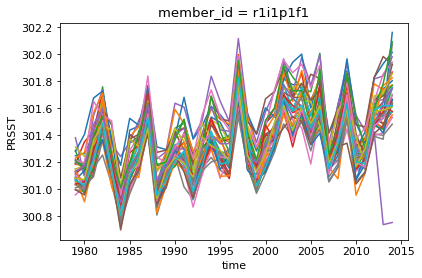

In [113]:
fig,ax = plt.subplots()
ta_amip.PRSST.plot(x="time",hue="model_id")
ax.legend().remove()

In [114]:
ta_trend_cmip6

<xarray.Dataset>
Dimensions:      (model_id: 40)
Coordinates:
    member_id    <U8 'r1i1p1f1'
  * model_id     (model_id) object 'ACCESS-CM2' ... 'EC-Earth3-CC'
Data variables:
    ta250_trend  (model_id) float64 0.2282 0.2336 0.2384 ... 0.2568 0.2589
    PRSST_trend  (model_id) float64 0.1121 0.09872 0.1005 ... 0.1179 0.1245
    ta700_trend  (model_id) float64 0.1545 0.1479 0.1418 ... 0.1474 0.1582
    ta300_trend  (model_id) float64 0.2224 0.2236 0.2356 ... 0.2501 0.2501

In [115]:
ta_trend_cmip6_corr = ta_trend_cmip6.drop_sel(model_id = 'CMCC-CM2-HR4')

In [116]:
ta_trend_cmip6_corr

<xarray.Dataset>
Dimensions:      (model_id: 39)
Coordinates:
    member_id    <U8 'r1i1p1f1'
  * model_id     (model_id) object 'ACCESS-CM2' ... 'EC-Earth3-CC'
Data variables:
    ta250_trend  (model_id) float64 0.2282 0.2336 0.2384 ... 0.2568 0.2589
    PRSST_trend  (model_id) float64 0.1121 0.09872 0.1005 ... 0.1179 0.1245
    ta700_trend  (model_id) float64 0.1545 0.1479 0.1418 ... 0.1474 0.1582
    ta300_trend  (model_id) float64 0.2224 0.2236 0.2356 ... 0.2501 0.2501

In [117]:
ta_trend_low_cprcon = ta_trend_ICON.sel(member=low_cprcon_members)
ta_trend_high_cprcon = ta_trend_ICON.sel(member=high_cprcon_members)
ta_trend_high_entrpen = ta_trend_ICON.sel(member=high_entrpen_members)
ta_trend_very_high_entrpen = ta_trend_ICON.sel(member=very_high_entrpen_members)
ta_trend_low_entrpen = ta_trend_ICON.sel(member=low_entrpen_members)
ta_trend_reference = ta_trend_ICON.sel(member=reference_members)

In [118]:
ta_trend_low_cprcon_2012 = ta_trend_ICON_2012.sel(member=low_cprcon_members)
ta_trend_high_cprcon_2012 = ta_trend_ICON_2012.sel(member=high_cprcon_members)
ta_trend_high_entrpen_2012 = ta_trend_ICON_2012.sel(member=high_entrpen_members)
ta_trend_very_high_entrpen_2012 = ta_trend_ICON_2012.sel(member=very_high_entrpen_members)
ta_trend_low_entrpen_2012 = ta_trend_ICON_2012.sel(member=low_entrpen_members)
ta_trend_reference_2012 = ta_trend_ICON_2012.sel(member=reference_members)

Observations

In [119]:
ta_trend_IUK_2014 = xr_linear_regression(ta_obs_iuk_1979_2014_ym.mean('station'),'ta700','time') * 10.
ta_trend_IUK_2014['ta250_trend'] = xr_linear_regression(ta_obs_iuk_1979_2014_ym.mean('station'),'ta250','time').trend * 10.

ta_trend_rich_2014 = xr_linear_regression(ta_obs_rich_ym_tropics_2014,'ta700','time') * 10.
ta_trend_rich_2014['ta250_trend'] = xr_linear_regression(ta_obs_rich_ym_tropics_2014,'ta250','time').trend * 10.

ta_trend_raobcore_2014 = xr_linear_regression(ta_raobcore_ym_tropics_2014,'ta700','time') * 10.
ta_trend_raobcore_2014['ta250_trend'] = xr_linear_regression(ta_raobcore_ym_tropics_2014,'ta250','time').trend * 10.

ta_trend_ratpac_2014 = xr_linear_regression(ta_ratpac_ym_tropical_mean,'ta700','time') * 10.
ta_trend_ratpac_2014['ta250_trend'] = xr_linear_regression(ta_ratpac_ym_tropical_mean,'ta250','time').trend * 10.

ta_trend_suny_2014 = xr_linear_regression(ta_suny_2014_ym,'ta700','time') * 10.
ta_trend_suny_2014['ta250_trend'] = xr_linear_regression(ta_suny_2014_ym,'ta250','time').trend * 10.


ta_trend_ERA_2014 = xr_linear_regression(ta_era_2014,'ta700','time') * 10.
ta_trend_ERA_2014['ta250_trend'] = xr_linear_regression(ta_era_2014,'ta250','time').trend * 10.

ta_trend_ERA_2014['PRSST_trend'] = xr_linear_regression(PRSST_era,'PRSST','time').trend * 10.


In [120]:
ta_trend_IUK_2012 = xr_linear_regression(ta_obs_iuk_1979_2014_ym.mean('station').sel(time=slice(1979,2012)),'ta700','time') * 10.
ta_trend_IUK_2012['ta250_trend'] = xr_linear_regression(ta_obs_iuk_1979_2014_ym.mean('station').sel(time=slice(1979,2012)),'ta250','time').trend * 10.

ta_trend_rich_2012 = xr_linear_regression(ta_obs_rich_ym_tropics_2014.sel(time=slice(1979,2012)),'ta700','time') * 10.
ta_trend_rich_2012['ta250_trend'] = xr_linear_regression(ta_obs_rich_ym_tropics_2014.sel(time=slice(1979,2012)),'ta250','time').trend * 10.

ta_trend_rich_ens_2012 = xr_linear_regression(ta_obs_rich_ens_ym_tropics.load().sel(time=slice(1979,2012)),'ta700','time') * 10.
ta_trend_rich_ens_2012['ta250_trend'] = xr_linear_regression(ta_obs_rich_ens_ym_tropics.load().sel(time=slice(1979,2012)),'ta250','time').trend * 10.


ta_trend_rich_tau_2012 = xr_linear_regression(ta_tau_rich_ym_tropics.sel(time=slice(1979,2012)).load(),'ta700','time') * 10.
ta_trend_rich_tau_2012['ta250_trend'] = xr_linear_regression(ta_tau_rich_ym_tropics.sel(time=slice(1979,2012)).load(),'ta250','time').trend * 10.


ta_trend_raobcore_2012 = xr_linear_regression(ta_raobcore_ym_tropics_2014.sel(time=slice(1979,2012)),'ta700','time') * 10.
ta_trend_raobcore_2012['ta250_trend'] = xr_linear_regression(ta_raobcore_ym_tropics_2014.sel(time=slice(1979,2012)),'ta250','time').trend * 10.

ta_trend_ratpac_2012 = xr_linear_regression(ta_ratpac_ym_tropical_mean.sel(time=slice(1979,2012)),'ta700','time') * 10.
ta_trend_ratpac_2012['ta250_trend'] = xr_linear_regression(ta_ratpac_ym_tropical_mean.sel(time=slice(1979,2012)),'ta250','time').trend * 10.

ta_trend_suny_2012 = xr_linear_regression(ta_suny_2014_ym.sel(time=slice(1979,2012)),'ta700','time') * 10.
ta_trend_suny_2012['ta250_trend'] = xr_linear_regression(ta_suny_2014_ym.sel(time=slice(1979,2012)),'ta250','time').trend * 10.


ta_trend_ERA_2012 = xr_linear_regression(ta_era_2014.sel(time=slice(1979,2012)),'ta700','time') * 10.
ta_trend_ERA_2012['ta250_trend'] = xr_linear_regression(ta_era_2014.sel(time=slice(1979,2012)),'ta250','time').trend * 10.
ta_trend_ERA_2012['PRSST_trend'] = xr_linear_regression(PRSST_era.sel(time=slice(1979,2012)),'PRSST','time').trend * 10.

ta_trend_hadat_2012 = xr_linear_regression(ta_hadat_1979_2012,'ta700','time') * 10.
ta_trend_hadat_2012['ta250_trend'] = xr_linear_regression(ta_hadat_1979_2012,'ta250','time').trend * 10.


/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [121]:
temperatures_cb = np.linspace(293.1054,295.54195,30)


def theoretical_trends(formula='pseudo', epsilon=0.3) :
    temp_intervals = np.arange(0.005,0.1,0.005)
    time = np.arange(1979.,2015.)
    qt=15.e-3
    trend_250_list = [0.]
    trend_700_list = [0.]

    for (i, interval) in enumerate(temp_intervals) :
        temperatures = np.arange(0,len(time)) * interval + 281.
        # chosing theses temps for the entaining plume ensures a similar temperature
        # range at 700hPa for espilon = 0.3:
        temperatures_cb = temperatures + 13.
        #print(temperatures)
        
        T_250=[]
        T_700=[]
        for (i,T) in enumerate(temperatures) :
            if formula == 'entrainment' :
                delta_T, Tx, Px = metcalc.dT_entrainment_700(temperatures_cb[i],96000.,0.8,epsilon)
                #print(Tx[0])
            else :
                Tx, Px = metcalc.integrate_dTdP(T,70000.,15000.,-100., qt, formula=formula)
            index_250hPa = np.where( Px == 25000 )
            T_250.append(Tx[index_250hPa])
            T_700.append(Tx[0])

        trend_250 = calc_slope(list(time), [ float(l) for l in T_250 ]) * 10.
        trend_700 = calc_slope(list(time), [ float(l) for l in T_700 ]) *10.

        trend_250_list.append(trend_250)
        trend_700_list.append(trend_700)
        
    return trend_700_list,trend_250_list

In [122]:
print(epsilon)

0.3


In [123]:
trend_entr_700,trend_entr_250 = theoretical_trends(formula='entrainment',epsilon = epsilon)

In [124]:
trend_pseudo_700,trend_pseudo_250 = theoretical_trends(formula='pseudo')
trend_revers_700,trend_revers_250 = theoretical_trends(formula='isentropic')
trend_pseudo_ice_700,trend_pseudo_ice_250 = theoretical_trends(formula='pseudo-ice')
trend_entr_700,trend_entr_250 = theoretical_trends(formula='entrainment',epsilon = epsilon)

In [125]:
correlation_PRSST_ta250 = metcalc.pearson_correlation(ta_trend_cmip6_corr.dropna(dim='model_id').PRSST_trend, ta_trend_cmip6_corr.dropna(dim='model_id').ta250_trend , 'model_id')
correlation_PRSST_ta250_2012 = metcalc.pearson_correlation(ta_trend_cmip6_2012.dropna(dim='model_id').PRSST_trend, ta_trend_cmip6_2012.dropna(dim='model_id').ta250_trend , 'model_id')


In [126]:
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 7})

In [129]:
correlation_ta700_ta250 = metcalc.pearson_correlation(ta_trend_cmip6_corr.ta700_trend, ta_trend_cmip6_corr.ta250_trend , 'model_id')

correlation_ta700_ta250_2012 = metcalc.pearson_correlation(ta_trend_cmip6_2012.ta700_trend, ta_trend_cmip6_2012.ta250_trend , 'model_id')


In [130]:
# Our model is y = a * x, so things are quite simple, in this case...
# x needs to be a column vector instead of a 1D vector for this, however.

x=ta_trend_cmip6.ta700_trend.values
y=ta_trend_cmip6.ta250_trend.values
x = x[:,np.newaxis]

slope_cmip, _, _, _ = np.linalg.lstsq(x, y)


/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [131]:
# Our model is y = a * x, so things are quite simple, in this case...
# x needs to be a column vector instead of a 1D vector for this, however.

x=ta_trend_cmip6_2012.ta700_trend.values
y=ta_trend_cmip6_2012.ta250_trend.values
x = x[:,np.newaxis]

slope_cmip_2012, _, _, _ = np.linalg.lstsq(x, y)


/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


### 1979- 2012

/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


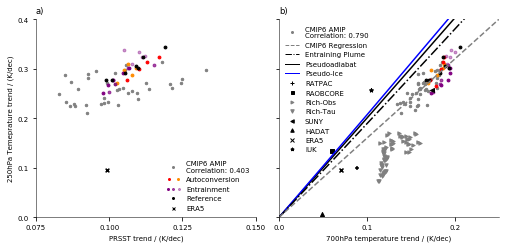

In [132]:
fig, axes = plt.subplots(1,2, figsize=(18/2.54,8.8/2.54),facecolor='w',sharey=True)

lines=[]
ax=axes[0]

ta_trend_cmip6_2012.plot.scatter(x='PRSST_trend',y='ta250_trend',color='grey',s=6,ax=ax)
lines.append(mlines.Line2D([], [], color='grey',marker='o',markersize=2, label='CMIP6 AMIP\nCorrelation: %.3f'%(correlation_PRSST_ta250.values), linewidth=0))

ta_trend_low_cprcon_2012.plot.scatter(x='PRSST_trend',y='ta250_trend',color='darkorange',s=8,ax=ax)
ta_trend_high_cprcon_2012.plot.scatter(x='PRSST_trend',y='ta250_trend',color='red',s=8,ax=ax)

lines.append(mlines.Line2D([], [], color='red',marker='o',markersize=2, label='Autoconversion', linewidth=0))
lines.append(mlines.Line2D([], [], color='darkorange',marker='o',markersize=2, label='Autoconversion', linewidth=0))


ta_trend_low_entrpen_2012.plot.scatter(x='PRSST_trend',y='ta250_trend',color='purple',s=8,alpha=0.4,ax=ax)
ta_trend_high_entrpen_2012.plot.scatter(x='PRSST_trend',y='ta250_trend',color='purple',s=8,alpha=0.7,ax=ax)
ta_trend_very_high_entrpen_2012.plot.scatter(x='PRSST_trend',y='ta250_trend',color='purple',s=8,alpha=1,ax=ax)
ta_trend_reference_2012.plot.scatter(x='PRSST_trend',y='ta250_trend',color='black',s=8,ax=ax)
lines.append(mlines.Line2D([], [], color='purple',marker='o',markersize=2, label='Entrainment', linewidth=0))
lines.append(mlines.Line2D([], [], color='purple',marker='o',markersize=2, label='Entrainment', linewidth=0,alpha=0.7))
lines.append(mlines.Line2D([], [], color='purple',marker='o',markersize=2, label='Entrainment', linewidth=0,alpha=0.4))
lines.append(mlines.Line2D([], [], color='black',marker='o',markersize=2, label='Reference', linewidth=0))

ta_trend_ERA_2012.plot.scatter(x='PRSST_trend',y='ta250_trend',color='black',s=14,marker='x',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='x',markersize=3, label='Reference', linewidth=0))

#ax.text(s='correlation: %.3f'%(correlation_PRSST_ta250.values) ,x=0.14,y=0.26,color='grey')
from matplotlib.legend_handler import HandlerLine2D,HandlerTuple

ax.set_xlabel('PRSST trend / (K/dec)')
ax.set_ylabel('250hPa Temeprature trend / (K/dec)')
ax.legend([lines[0],(lines[1],lines[2]),(lines[3],lines[4],lines[5]),lines[6],lines[7]],
          ["CMIP6 AMIP\nCorrelation: %.3f"%(correlation_PRSST_ta250_2012.values),
           "Autoconversion","Entrainment","Reference","ERA5"],
          ncol=1,frameon=False,loc=4,numpoints=1,
          handler_map={tuple: HandlerTuple(ndivide=None)})

ax.set_ylim([0,0.4])
ax.set_yticks([0.1,0.2,0.3,0.4])
ax.set_xticks([0.075,0.1,0.125,0.15])
ax.set_xlim([0.075,0.15])
ax.set_title('a)',loc='left')

metcalc.remove_axes(ax)


ax=axes[1]
lines=[]



ax.plot(trend_pseudo_700,trend_pseudo_250, color='black')
ax.plot(trend_pseudo_ice_700,trend_pseudo_ice_250, color='blue')
ax.plot(trend_entr_700,trend_entr_250, color='black',ls='-.')

ta_trend_cmip6_2012.plot.scatter(x='ta700_trend',y='ta250_trend',color='grey',s=6,ax=ax)
lines.append(mlines.Line2D([], [], color='grey',marker='o',markersize=2, label='CMIP6 AMIP\nCorrelation: %.3f'%(correlation_ta700_ta250_2012.values), linewidth=0))

ax.plot(np.array((0.,0.25)), slope_cmip_2012*np.array((0.,0.25)), color='grey',ls='--' )
lines.append(mlines.Line2D([], [], color='grey',linewidth=1, label='CMIP6 Regression',ls='--'))

lines.append(mlines.Line2D([], [], color='black',linewidth=1,ls='-.', label='Entraining Plume'))                          
lines.append(mlines.Line2D([], [], color='black',linewidth=1, label='Pseudoadiabat'))
lines.append(mlines.Line2D([], [], color='blue',linewidth=1, label='Pseudo-Ice'))

ta_trend_low_cprcon_2012.plot.scatter(x='ta700_trend',y='ta250_trend',color='darkorange',s=8,ax=ax)
ta_trend_high_cprcon_2012.plot.scatter(x='ta700_trend',y='ta250_trend',color='red',s=8,ax=ax)

ta_trend_low_entrpen_2012.plot.scatter(x='ta700_trend',y='ta250_trend',color='purple',s=8,alpha=0.4,ax=ax)
ta_trend_high_entrpen_2012.plot.scatter(x='ta700_trend',y='ta250_trend',color='purple',s=8,alpha=0.7,ax=ax)
ta_trend_very_high_entrpen_2012.plot.scatter(x='ta700_trend',y='ta250_trend',color='purple',s=8,alpha=1,ax=ax)
ta_trend_reference_2012.plot.scatter(x='ta700_trend',y='ta250_trend',color='black',s=8,ax=ax)

ta_trend_ratpac_2012.plot.scatter(x='trend',y='ta250_trend',color='black',s=20, marker='+',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='+',markersize=3.5, label='RATPAC', linewidth=0))
ta_trend_raobcore_2012.plot.scatter(x='trend',y='ta250_trend',color='black',s=16, marker='s',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='s',markersize=3, label='RAOBCORE', linewidth=0))
ta_trend_rich_ens_2012.plot.scatter(x='trend',y='ta250_trend',hue="member",color='grey',s=11, marker='>',ax=ax)
lines.append(mlines.Line2D([], [], color='grey',marker='>',markersize=3, label='Rich-Obs', linewidth=0))
ta_trend_rich_tau_2012.plot.scatter(x='trend',y='ta250_trend',color='grey',s=11, marker='v',ax=ax,hue="member")
lines.append(mlines.Line2D([], [], color='grey',marker='v',markersize=3.5, label='Rich-Tau', linewidth=0))
ta_trend_suny_2012.plot.scatter(x='trend',y='ta250_trend',color='black',s=16, marker='<',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='<',markersize=3.5, label='SUNY', linewidth=0))
ta_trend_hadat_2012.plot.scatter(x='trend',y='ta250_trend',color='black',s=16, marker='^',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='^',markersize=3.5, label='HADAT', linewidth=0))
ta_trend_ERA_2012.plot.scatter(x='trend',y='ta250_trend',color='black',s=16, marker='x',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='x',markersize=3.5, label='ERA5', linewidth=0))
ta_trend_IUK_2012.plot.scatter(x='trend',y='ta250_trend',color='black',s=16, marker='*',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='*',markersize=3.5, label='IUK', linewidth=0))

ax.set_xlabel('700hPa temperature trend / (K/dec)')
ax.set_ylabel('')
ax.legend(handles=lines,ncol=1,frameon=False,loc=2)

ax.set_xlim([0,0.25])
ax.set_ylim([0,0.4])
ax.set_xticks([0.,0.1,0.2])
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_title('b)',loc='left')

metcalc.remove_axes(ax)

plt.savefig('../plots/ta700vs250_trend_2012.pdf', dpi=600)


### 1979-2014

Use cmip6 without the 'CMCC-CM2-HR4' model

/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


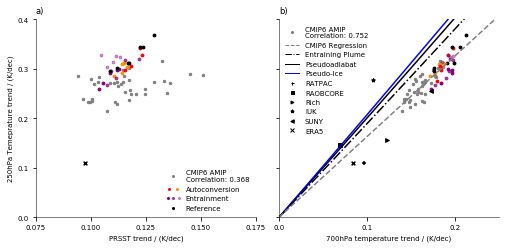

In [133]:
fig, axes = plt.subplots(1,2, figsize=(18/2.54,8.8/2.54),facecolor='w',sharey=True)

lines=[]
ax=axes[0]

ta_trend_cmip6_corr.plot.scatter(x='PRSST_trend',y='ta250_trend',color='grey',s=6,ax=ax)
lines.append(mlines.Line2D([], [], color='grey',marker='o',markersize=2, label='CMIP6 AMIP\nCorrelation: %.3f'%(correlation_PRSST_ta250.values), linewidth=0))

ta_trend_low_cprcon.plot.scatter(x='PRSST_trend',y='ta250_trend',color='darkorange',s=8,ax=ax)
ta_trend_high_cprcon.plot.scatter(x='PRSST_trend',y='ta250_trend',color='red',s=8,ax=ax)

lines.append(mlines.Line2D([], [], color='red',marker='o',markersize=2, label='Autoconversion', linewidth=0))
lines.append(mlines.Line2D([], [], color='darkorange',marker='o',markersize=2, label='Autoconversion', linewidth=0))


ta_trend_low_entrpen.plot.scatter(x='PRSST_trend',y='ta250_trend',color='purple',s=8,alpha=0.4,ax=ax)
ta_trend_high_entrpen.plot.scatter(x='PRSST_trend',y='ta250_trend',color='purple',s=8,alpha=0.7,ax=ax)
ta_trend_very_high_entrpen.plot.scatter(x='PRSST_trend',y='ta250_trend',color='purple',s=8,alpha=1,ax=ax)
ta_trend_reference.plot.scatter(x='PRSST_trend',y='ta250_trend',color='black',s=8,ax=ax)
lines.append(mlines.Line2D([], [], color='purple',marker='o',markersize=2, label='Entrainment', linewidth=0))
lines.append(mlines.Line2D([], [], color='purple',marker='o',markersize=2, label='Entrainment', linewidth=0,alpha=0.7))
lines.append(mlines.Line2D([], [], color='purple',marker='o',markersize=2, label='Entrainment', linewidth=0,alpha=0.4))
lines.append(mlines.Line2D([], [], color='black',marker='o',markersize=2, label='Reference', linewidth=0))


ta_trend_ERA_2014.plot.scatter(x='PRSST_trend',y='ta250_trend',color='black',s=14,marker='x',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='x',markersize=2, label='Reference', linewidth=0))

#ax.text(s='correlation: %.3f'%(correlation_PRSST_ta250.values) ,x=0.14,y=0.26,color='grey')
from matplotlib.legend_handler import HandlerLine2D,HandlerTuple

ax.set_xlabel('PRSST trend / (K/dec)')
ax.set_ylabel('250hPa Temeprature trend / (K/dec)')
ax.legend([lines[0],(lines[1],lines[2]),(lines[3],lines[4],lines[5]),lines[6]],
          ["CMIP6 AMIP\nCorrelation: %.3f"%(correlation_PRSST_ta250.values),
           "Autoconversion","Entrainment","Reference"],
          ncol=1,frameon=False,loc=4,numpoints=1,
          handler_map={tuple: HandlerTuple(ndivide=None)})

#ax.set_ylim([0,0.4])
#ax.set_xlim([281.5,283.5])
ax.set_yticks([0.1,0.2,0.3,0.4])
ax.set_xticks([0.075,0.1,0.125,0.15,0.175])
#ax.set_xlim([0.075,0.175])
ax.set_title('a)',loc='left')

metcalc.remove_axes(ax)


ax=axes[1]
lines=[]



ax.plot(trend_pseudo_700,trend_pseudo_250, color='black')
ax.plot(trend_pseudo_ice_700,trend_pseudo_ice_250, color='blue')
ax.plot(trend_entr_700,trend_entr_250, color='black',ls='-.')

ta_trend_cmip6_corr.plot.scatter(x='ta700_trend',y='ta250_trend',color='grey',s=6,ax=ax)
lines.append(mlines.Line2D([], [], color='grey',marker='o',markersize=2, label='CMIP6 AMIP\nCorrelation: %.3f'%(correlation_ta700_ta250.values), linewidth=0))

ax.plot(np.array((0.,0.25)), slope_cmip*np.array((0.,0.25)), color='grey',ls='--' )
lines.append(mlines.Line2D([], [], color='grey',linewidth=1, label='CMIP6 Regression',ls='--'))

lines.append(mlines.Line2D([], [], color='black',linewidth=1,ls='-.', label='Entraining Plume'))                          
lines.append(mlines.Line2D([], [], color='black',linewidth=1, label='Pseudoadiabat'))
lines.append(mlines.Line2D([], [], color='blue',linewidth=1, label='Pseudo-Ice'))

ta_trend_low_cprcon.plot.scatter(x='ta700_trend',y='ta250_trend',color='darkorange',s=8,ax=ax)
ta_trend_high_cprcon.plot.scatter(x='ta700_trend',y='ta250_trend',color='red',s=8,ax=ax)

ta_trend_low_entrpen.plot.scatter(x='ta700_trend',y='ta250_trend',color='purple',s=8,alpha=0.4,ax=ax)
ta_trend_high_entrpen.plot.scatter(x='ta700_trend',y='ta250_trend',color='purple',s=8,alpha=0.7,ax=ax)
ta_trend_very_high_entrpen.plot.scatter(x='ta700_trend',y='ta250_trend',color='purple',s=8,alpha=1,ax=ax)
ta_trend_reference.plot.scatter(x='ta700_trend',y='ta250_trend',color='black',s=8,ax=ax)

ta_trend_ratpac_2014.plot.scatter(x='trend',y='ta250_trend',color='black',s=14, marker='+',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='+',markersize=3, label='RATPAC', linewidth=0))
ta_trend_raobcore_2014.plot.scatter(x='trend',y='ta250_trend',color='black',s=14, marker='s',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='s',markersize=3, label='RAOBCORE', linewidth=0))
ta_trend_rich_2014.plot.scatter(x='trend',y='ta250_trend',color='black',s=14, marker='>',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='>',markersize=3, label='Rich', linewidth=0))
ta_trend_IUK_2014.plot.scatter(x='trend',y='ta250_trend',color='black',s=14, marker='*',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='*',markersize=3.5, label='IUK', linewidth=0))
ta_trend_suny_2014.plot.scatter(x='trend',y='ta250_trend',color='black',s=14, marker='<',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='<',markersize=3.5, label='SUNY', linewidth=0))
ta_trend_ERA_2014.plot.scatter(x='trend',y='ta250_trend',color='black',s=14, marker='x',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='x',markersize=3.5, label='ERA5', linewidth=0))

ax.set_xlabel('700hPa temperature trend / (K/dec)')
ax.set_ylabel('')
ax.legend(handles=lines,ncol=1,frameon=False,loc=2)

ax.set_xlim([0,0.25])
ax.set_ylim([0,0.4])
ax.set_xticks([0.,0.1,0.2])
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_title('b)',loc='left')

metcalc.remove_axes(ax)


Check with stronger entrainment:

In [134]:
trend_entr_700_08,trend_entr_250_08 = theoretical_trends(formula='entrainment',epsilon = 0.8)

/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


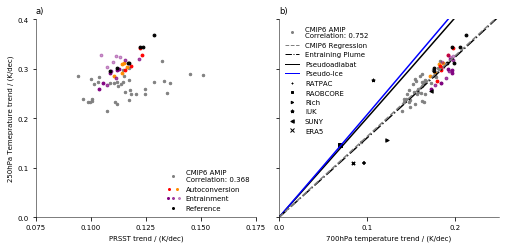

In [135]:
fig, axes = plt.subplots(1,2, figsize=(18/2.54,8.8/2.54),facecolor='w',sharey=True)

lines=[]
ax=axes[0]

ta_trend_cmip6_corr.plot.scatter(x='PRSST_trend',y='ta250_trend',color='grey',s=6,ax=ax)
lines.append(mlines.Line2D([], [], color='grey',marker='o',markersize=2, label='CMIP6 AMIP\nCorrelation: %.3f'%(correlation_PRSST_ta250.values), linewidth=0))

ta_trend_low_cprcon.plot.scatter(x='PRSST_trend',y='ta250_trend',color='darkorange',s=8,ax=ax)
ta_trend_high_cprcon.plot.scatter(x='PRSST_trend',y='ta250_trend',color='red',s=8,ax=ax)

lines.append(mlines.Line2D([], [], color='red',marker='o',markersize=2, label='Autoconversion', linewidth=0))
lines.append(mlines.Line2D([], [], color='darkorange',marker='o',markersize=2, label='Autoconversion', linewidth=0))


ta_trend_low_entrpen.plot.scatter(x='PRSST_trend',y='ta250_trend',color='purple',s=8,alpha=0.4,ax=ax)
ta_trend_high_entrpen.plot.scatter(x='PRSST_trend',y='ta250_trend',color='purple',s=8,alpha=0.7,ax=ax)
ta_trend_very_high_entrpen.plot.scatter(x='PRSST_trend',y='ta250_trend',color='purple',s=8,alpha=1,ax=ax)
ta_trend_reference.plot.scatter(x='PRSST_trend',y='ta250_trend',color='black',s=8,ax=ax)
lines.append(mlines.Line2D([], [], color='purple',marker='o',markersize=2, label='Entrainment', linewidth=0))
lines.append(mlines.Line2D([], [], color='purple',marker='o',markersize=2, label='Entrainment', linewidth=0,alpha=0.7))
lines.append(mlines.Line2D([], [], color='purple',marker='o',markersize=2, label='Entrainment', linewidth=0,alpha=0.4))
lines.append(mlines.Line2D([], [], color='black',marker='o',markersize=2, label='Reference', linewidth=0))

#ax.text(s='correlation: %.3f'%(correlation_PRSST_ta250.values) ,x=0.14,y=0.26,color='grey')
from matplotlib.legend_handler import HandlerLine2D,HandlerTuple

ax.set_xlabel('PRSST trend / (K/dec)')
ax.set_ylabel('250hPa Temeprature trend / (K/dec)')
ax.legend([lines[0],(lines[1],lines[2]),(lines[3],lines[4],lines[5]),lines[6]],
          ["CMIP6 AMIP\nCorrelation: %.3f"%(correlation_PRSST_ta250.values),
           "Autoconversion","Entrainment","Reference"],
          ncol=1,frameon=False,loc=4,numpoints=1,
          handler_map={tuple: HandlerTuple(ndivide=None)})

ax.set_ylim([0,0.4])
ax.set_xlim([281.5,283.5])
ax.set_yticks([0.1,0.2,0.3,0.4])
ax.set_xticks([0.075,0.1,0.125,0.15,0.175])
ax.set_xlim([0.075,0.175])
ax.set_title('a)',loc='left')

metcalc.remove_axes(ax)


ax=axes[1]
lines=[]



ax.plot(trend_pseudo_700,trend_pseudo_250, color='black')
ax.plot(trend_pseudo_ice_700,trend_pseudo_ice_250, color='blue')
ax.plot(trend_entr_700_08,trend_entr_250_08, color='black',ls='-.')

ta_trend_cmip6.plot.scatter(x='ta700_trend',y='ta250_trend',color='grey',s=6,ax=ax)
lines.append(mlines.Line2D([], [], color='grey',marker='o',markersize=2, label='CMIP6 AMIP\nCorrelation: %.3f'%(correlation_ta700_ta250.values), linewidth=0))

ax.plot(np.array((0.,0.25)), slope_cmip*np.array((0.,0.25)), color='grey',ls='--' )
lines.append(mlines.Line2D([], [], color='grey',linewidth=1, label='CMIP6 Regression',ls='--'))

lines.append(mlines.Line2D([], [], color='black',linewidth=1,ls='-.', label='Entraining Plume'))                          
lines.append(mlines.Line2D([], [], color='black',linewidth=1, label='Pseudoadiabat'))
lines.append(mlines.Line2D([], [], color='blue',linewidth=1, label='Pseudo-Ice'))

ta_trend_low_cprcon.plot.scatter(x='ta700_trend',y='ta250_trend',color='darkorange',s=8,ax=ax)
ta_trend_high_cprcon.plot.scatter(x='ta700_trend',y='ta250_trend',color='red',s=8,ax=ax)

ta_trend_low_entrpen.plot.scatter(x='ta700_trend',y='ta250_trend',color='purple',s=8,alpha=0.4,ax=ax)
ta_trend_high_entrpen.plot.scatter(x='ta700_trend',y='ta250_trend',color='purple',s=8,alpha=0.7,ax=ax)
ta_trend_very_high_entrpen.plot.scatter(x='ta700_trend',y='ta250_trend',color='purple',s=8,alpha=1,ax=ax)
ta_trend_reference.plot.scatter(x='ta700_trend',y='ta250_trend',color='black',s=8,ax=ax)

ta_trend_ratpac_2014.plot.scatter(x='trend',y='ta250_trend',color='black',s=11, marker='+',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='+',markersize=2.5, label='RATPAC', linewidth=0))
ta_trend_raobcore_2014.plot.scatter(x='trend',y='ta250_trend',color='black',s=11, marker='s',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='s',markersize=2.5, label='RAOBCORE', linewidth=0))
ta_trend_rich_2014.plot.scatter(x='trend',y='ta250_trend',color='black',s=11, marker='>',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='>',markersize=2.5, label='Rich', linewidth=0))
ta_trend_IUK_2014.plot.scatter(x='trend',y='ta250_trend',color='black',s=11, marker='*',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='*',markersize=3.5, label='IUK', linewidth=0))
ta_trend_suny_2014.plot.scatter(x='trend',y='ta250_trend',color='black',s=11, marker='<',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='<',markersize=3.5, label='SUNY', linewidth=0))
ta_trend_ERA_2014.plot.scatter(x='trend',y='ta250_trend',color='black',s=11, marker='x',ax=ax)
lines.append(mlines.Line2D([], [], color='black',marker='x',markersize=3.5, label='ERA5', linewidth=0))

ax.set_xlabel('700hPa temperature trend / (K/dec)')
ax.set_ylabel('')
ax.legend(handles=lines,ncol=1,frameon=False,loc=2)

ax.set_xlim([0,0.25])
ax.set_ylim([0,0.4])
ax.set_xticks([0.,0.1,0.2])
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_title('b)',loc='left')

metcalc.remove_axes(ax)
